<a href="https://colab.research.google.com/github/HNXJ/GSDR/blob/main/G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resembling high-density electrophysiology

Spectral power tuning in Hodgkin-Huxley based biophysical neuronal network

 Part of the supplements of *"A genetic algorithm for self-supervised models of oscillatory neurodynamics (2025, under-review)"*


## Description

In these simulations, Hodgkin-Huxley based biophysical networks are trained to maximize the coherence bewteen the model's power spectrum density (PSD) and  in-vivo recorded single neurons PSD.

Network consists of 50 neurons (36 excitatory, 14 inhibitory) with uniform synaptic time constants and initial synaptic conductances. Connectivity pattern of all neurons except 7 (half) of inhibitory neurons which are restricted to have 10 or less connections as a presynaptic neuros (This is explained in the results section, to resemble local PV-like interneurons)

Objective is to replicate a stimulus dependent push-pull (Bastos et. al, 2020) between lower frequency alpha/beta (~ 8-30Hz) and gamma (~32Hz+) bands. More specifically, this push-pull is observed in single neurons recorded with dense laminar neurophysiology data in non-human primates (macaque) visual cortex area(s) MT/MST during active visual presentation of a moving grating (Westerberg et. al, 2024). In addition, the stimulus evoked gamma is relatively narrow band (37.5Hz +- 2Hz).

## Setup

### Packages

In [1]:
%pip install jaxley
from jax import config
config.update("jax_enable_x64", False)
config.update("jax_platform_name", "gpu") # 'gpu' / 'cpu'
# config.update("jax_debug_nans", True)

import jax
import numpy as np
import jaxley as jx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxley.optimize.transforms as jt

from jax import jit, vmap, value_and_grad
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, sparse_connect, connect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.2/238.2 kB 6.1 MB/s eta 0:00:00


### Data

Multi-area Dense Laminar Neurophysiology (MaDeLaNe) in Neurodata without border (NWB) format


Functions for nwb data loading:

In [ ]:
# @title
%pip install -U pynwb
import os
import pandas as pd
from pynwb import NWBHDF5IO


def get_binary_events_for_code(nwb_file, target_code=50.0, target_interval_name=None, code_column='codes'):
    """
    Extracts binary event indicators from an NWBFile object based on a target_code
    in a specified interval table.

    A '1' in the returned NumPy array indicates that the `code_column` in the specified
    `interval_table` matches the `target_code` at that row, and '0' otherwise.

    Args:
        nwb_file (pynwb.NWBFile): The NWBFile object to inspect.
        target_code (float): The code to match in the `code_column`.
        target_interval_name (str, optional): The name of a specific interval table to search.
                                            If None, the function will return an empty array
                                            if no specific table is designated.
        code_column (str): The name of the column in the interval table that contains the codes.
                           Defaults to 'codes'.

    Returns:
        numpy.ndarray: A binary NumPy array (1s and 0s) indicating rows where the code matches,
                       or an empty array if conditions are not met.
    """
    if not hasattr(nwb_file, 'intervals') or not nwb_file.intervals:
        print("No interval tables found in the NWB file.")
        return np.array([])

    if not target_interval_name or target_interval_name not in nwb_file.intervals:
        print(f"Warning: Specified interval table '{target_interval_name}' not found or not provided. Returning empty array.")
        return np.array([])

    interval_table = nwb_file.intervals[target_interval_name]
    df = interval_table.to_dataframe()

    if code_column not in df.columns:
        print(f"Warning: Interval table '{target_interval_name}' does not contain '{code_column}' column. Returning array of zeros.")
        return np.zeros(len(df), dtype=int)

    if 'start_time' not in df.columns:
        print(f"Warning: Interval table '{target_interval_name}' does not contain 'start_time' column. This may affect interpretation.")

    # Convert the column to numeric, coercing errors to NaN
    codes_for_comparison = pd.to_numeric(df[code_column], errors='coerce')

    # Create a boolean mask using robust floating-point comparison
    # np.isclose handles potential floating point inaccuracies. equal_nan=False treats NaNs as not equal.
    binary_mask = np.isclose(codes_for_comparison, target_code, equal_nan=False)

    # Convert boolean mask to integer array (True -> 1, False -> 0)
    binary_array = binary_mask.astype(int)

    return binary_array


def get_onset_time_bin(nwb_file, binary_event_array, target_interval_name):
    """
    Retrieves start_time values from the specified interval table based on a binary event array.

    Args:
        nwb_file (pynwb.NWBFile): The NWBFile object to inspect.
        binary_event_array (numpy.ndarray): A binary NumPy array where '1' indicates an event.
        target_interval_name (str): The name of the interval table from which to extract start_times.

    Returns:
        list: A list of start_time values corresponding to '1's in the binary_event_array.
              Returns an empty list if the interval table is not found or 'start_time' column is missing.
    """
    onset_times = []

    if not hasattr(nwb_file, 'intervals') or not nwb_file.intervals:
        print("No interval tables found in the NWB file.")
        return onset_times

    if not target_interval_name or target_interval_name not in nwb_file.intervals:
        print(f"Warning: Specified interval table '{target_interval_name}' not found or not provided. Returning empty list.")
        return onset_times

    interval_table = nwb_file.intervals[target_interval_name]
    df = interval_table.to_dataframe()

    if 'start_time' not in df.columns:
        print(f"Warning: Interval table '{target_interval_name}' does not contain 'start_time' column. Returning empty list.")
        return onset_times

    # Ensure binary_event_array matches the length of the DataFrame
    if len(binary_event_array) != len(df):
        print("Error: Length of binary_event_array does not match the length of the interval table. Returning empty list.")
        return onset_times

    # Filter start_times where the binary_event_array is 1
    onset_times = df['start_time'][binary_event_array == 1].tolist()

    return onset_times


def get_signal_array(nwb_file, event_timestamps, time_pre, time_post, signal_mode='lfp', probe_id=0, eye_dimension_index=0):
    signal_data_h5 = None
    signal_timestamps_h5 = None
    num_channels = 1
    signal_name = ""

    if signal_mode == 'lfp':
        signal_name = f'probe_{probe_id}_lfp'
        if signal_name in nwb_file.acquisition:
            electrical_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = electrical_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = electrical_series.timestamps # Store h5py.Dataset reference
            num_channels = signal_data_h5.shape[1] if signal_data_h5.ndim > 1 else 1
        else:
            print(f"Error: LFP data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'muae':
        signal_name = f'probe_{probe_id}_muae'
        if signal_name in nwb_file.acquisition:
            electrical_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = electrical_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = electrical_series.timestamps # Store h5py.Dataset reference
            num_channels = signal_data_h5.shape[1] if signal_data_h5.ndim > 1 else 1
        else:
            print(f"Error: MUAe data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'pupil':
        signal_name = 'pupil_1_tracking'
        if signal_name in nwb_file.acquisition:
            time_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            num_channels = 1 # Pupil is usually 1D
        else:
            print(f"Error: Pupil tracking data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'eye':
        signal_name = 'eye_1_tracking'
        if signal_name in nwb_file.acquisition:
            time_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            # Eye tracking data typically has 2 dimensions (X, Y)
            if signal_data_h5.ndim > 1 and signal_data_h5.shape[1] > eye_dimension_index:
                # We will slice this in the loop, so keep the full h5py.Dataset for now
                pass
            else:
                print(f"Warning: Eye tracking data has unexpected dimensions or eye_dimension_index {eye_dimension_index} is out of bounds. Using first dimension.")
            num_channels = 1 # We extract one dimension at a time for 'eye' mode
        else:
            print(f"Error: Eye tracking data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'photodiode': # Added photodiode handling
        signal_name = 'photodiode_1_tracking'
        if signal_name in nwb_file.acquisition:
            time_series = nwb_file.acquisition[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            num_channels = 1
        else:
            print(f"Error: Photodiode tracking data for {signal_name} not found.")
            return np.array([])
    elif signal_mode == 'convolved_spike_train':
        signal_name = 'convolved_spike_train_data'
        if 'convolved_spike_train' in nwb_file.processing and signal_name in nwb_file.processing['convolved_spike_train'].data_interfaces:
            time_series = nwb_file.processing['convolved_spike_train'].data_interfaces[signal_name]
            signal_data_h5 = time_series.data # Store h5py.Dataset reference
            signal_timestamps_h5 = time_series.timestamps # Store h5py.Dataset reference
            num_channels = signal_data_h5.shape[1] if signal_data_h5.ndim > 1 else 1
        else:
            print(f"Error: Convolved spike train data for {signal_name} not found.")
            return np.array([])
    else:
        print(f"Error: Invalid signal_mode '{signal_mode}'. Supported modes are 'lfp', 'muae', 'pupil', 'eye', 'photodiode', 'convolved_spike_train'.")
        return np.array([])

    if signal_data_h5 is None or signal_timestamps_h5 is None or len(signal_timestamps_h5) == 0:
        print(f"Error: No data or timestamps found for signal_mode '{signal_mode}'.")
        return np.array([])

    # Load timestamps fully, as they are typically smaller and needed for searchsorted/diff
    signal_timestamps = signal_timestamps_h5[:]

    if len(signal_timestamps) > 1:
        sampling_rate = 1 / np.mean(np.diff(signal_timestamps))
    else:
        print("Warning: Not enough timestamps to calculate sampling rate, assuming 1000 Hz.")
        sampling_rate = 1000.0

    num_time_points_in_window = int(np.round((time_pre + time_post) * sampling_rate))

    # Use dtype from the h5py.Dataset object
    if num_channels > 1 and signal_mode not in ['pupil', 'eye', 'photodiode']:
        result_array = np.full((len(event_timestamps), num_time_points_in_window, num_channels), np.nan, dtype=signal_data_h5.dtype)
    else:
        result_array = np.full((len(event_timestamps), num_time_points_in_window), np.nan, dtype=signal_data_h5.dtype)

    for i, event_ts in enumerate(event_timestamps):
        window_start_time = event_ts - time_pre
        window_end_time = event_ts + time_post

        start_idx = np.searchsorted(signal_timestamps, window_start_time, side='left')
        end_idx = np.searchsorted(signal_timestamps, window_end_time, side='right')

        data_segment_start_idx = max(0, start_idx)
        data_segment_end_idx = min(len(signal_timestamps_h5), end_idx)

        actual_samples_from_signal = data_segment_end_idx - data_segment_start_idx

        if actual_samples_from_signal <= 0:
            continue

        # Calculate the ideal start and end indices within the result_array for this event
        ideal_paste_start = int(np.round((signal_timestamps[data_segment_start_idx] - window_start_time) * sampling_rate))
        ideal_paste_end = ideal_paste_start + actual_samples_from_signal

        # Clamp these indices to the actual bounds of the result_array's window
        final_result_slice_start = max(0, ideal_paste_start)
        final_result_slice_end = min(num_time_points_in_window, ideal_paste_end)

        # Determine the corresponding slice within the current_data_segment
        source_data_start_offset = final_result_slice_start - ideal_paste_start
        source_data_end_offset = source_data_start_offset + (final_result_slice_end - final_result_slice_start)

        # Extract the relevant data segment by slicing the h5py.Dataset object
        if signal_mode == 'eye' and signal_data_h5.ndim > 1:
            current_data_segment = signal_data_h5[data_segment_start_idx:data_segment_end_idx, eye_dimension_index]
        else:
            current_data_segment = signal_data_h5[data_segment_start_idx:data_segment_end_idx]

        # Take the correct part of the extracted segment that fits into the result array
        segment_to_copy = current_data_segment[source_data_start_offset : source_data_end_offset]

        # Place data into the result array
        if num_channels > 1 and signal_mode not in ['pupil', 'eye', 'photodiode']:
            result_array[i, final_result_slice_start:final_result_slice_end, :] = segment_to_copy
        else:
            result_array[i, final_result_slice_start:final_result_slice_end] = segment_to_copy

    return result_array


def get_unit_column_data(nwb_file, column_label):
    """
    Retrieves data from a specified column of the nwb.units table.

    Args:
        nwb_file (pynwb.NWBFile): The NWBFile object containing the units data.
        column_label (str): The name of the column to retrieve (e.g., "snr", "presence_ratio").

    Returns:
        pandas.Series or None: A pandas Series containing the data from the specified column,
                              or None if the units table or column does not exist.
    """
    if nwb_file.units is None or len(nwb_file.units) == 0:
        print("Units table is empty or does not exist in the NWB file.")
        return None

    if column_label not in nwb_file.units.colnames:
        print(f"Column '{column_label}' not found in the units table. Available columns: {nwb_file.units.colnames}")
        return None

    df_units = nwb_file.units.to_dataframe()
    return df_units[column_label]


def get_neuron_info(nwb, unit_id):
    """
    Retrieves info for a specific neuron by ID.

    Args:
        nwb: The NWBFile object.
        unit_id: The ID of the neuron unit.

    Returns:
        peak_channel, id, snr, presence_ratio, area
    """
    if nwb.units is None:
        print("No units table found.")
        return None, unit_id, None, None, None

    # Get all unit IDs to find the index of the requested unit_id
    all_ids = nwb.units.id[:]

    try:
        index = list(all_ids).index(unit_id)
    except ValueError:
        print(f"Unit ID {unit_id} not found in nwb.units.")
        return None, unit_id, None, None, None

    # Helper to safely retrieve column data
    def get_col_val(col_name, idx):
        if col_name in nwb.units.colnames:
            return nwb.units[col_name][idx]
        return float('nan')

    # Retrieve requested values
    peak_channel = get_col_val('peak_channel_id', index)
    snr = get_col_val('snr', index)
    presence_ratio = get_col_val('presence_ratio', index)

    # Find Area from electrodes table
    area = "unknown"
    if nwb.electrodes is not None:
        try:
            # Convert peak_channel to int ID (handle string '3.0' -> 3)
            elec_id = int(float(peak_channel))

            # Find index in electrodes table
            # nwb.electrodes.id is a dataset containing IDs
            elec_ids = nwb.electrodes.id[:]
            if elec_id in elec_ids:
                elec_idx = list(elec_ids).index(elec_id)

                # Try 'location' first, usually holds area info
                if 'location' in nwb.electrodes.colnames:
                    val = nwb.electrodes['location'][elec_idx]
                    # Handle bytes vs string
                    area = val.decode('utf-8') if isinstance(val, bytes) else str(val)
                elif 'label' in nwb.electrodes.colnames:
                    val = nwb.electrodes['label'][elec_idx]
                    area = val.decode('utf-8') if isinstance(val, bytes) else str(val)
        except Exception as e:
            # area remains "unknown" or could be set to error message
            pass

    return peak_channel, unit_id, snr, presence_ratio, area




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 25.0 MB/s eta 0:00:00


In [3]:
# filepath = "/content/data/reconstructed_nwbdata"

from google.colab import drive
drive.mount('/content/drive/')

filepath = "/content/drive/MyDrive/Workspace/NWBData/"
nwb_files = []
for file in os.listdir(filepath):
    if file.endswith(".nwb"):
        nwb_files.append(os.path.join(filepath, file))

print("Found NWB files:")
for nwb_file in nwb_files:
    print(nwb_file)

filepath = nwb_files[3]

print(f"\nInspecting file: {filepath}")

io = NWBHDF5IO(filepath, 'r')
nwb = io.read()
print("\n[General File Info]")
print(nwb)

In [ ]:
target_interval = 'omission_glo_passive'

correct_b = get_binary_events_for_code(
    nwb,
    target_code=1.0,
    target_interval_name=target_interval,
    code_column='correct'
)

stim1_b = get_binary_events_for_code(
    nwb,
    target_code=2,
    target_interval_name=target_interval,
    code_column='stimulus_number'
)

ssss_s = get_binary_events_for_code(
    nwb,
    target_code=3,
    target_interval_name=target_interval,
    code_column='task_condition_number'
)

onset_times_from_first_stim_1 = get_onset_time_bin(
    nwb,
    correct_b & stim1_b & ssss_s,
    target_interval_name=target_interval
)

single_unit_spiking = get_signal_array(
    nwb_file=nwb,
    event_timestamps=onset_times_from_first_stim_1,
    time_pre=1.0, # Using 1 second before event, adjusted from 1000
    time_post=1.0, # Using 1 second after event, adjusted from 1000
    signal_mode='convolved_spike_train'
)

print(f"Shape of single_unit_spiking array: {single_unit_spiking.shape}")

Shape of single_unit_spiking array: (40, 2000, 541)


Unit IDs in 'MT, MST': 95


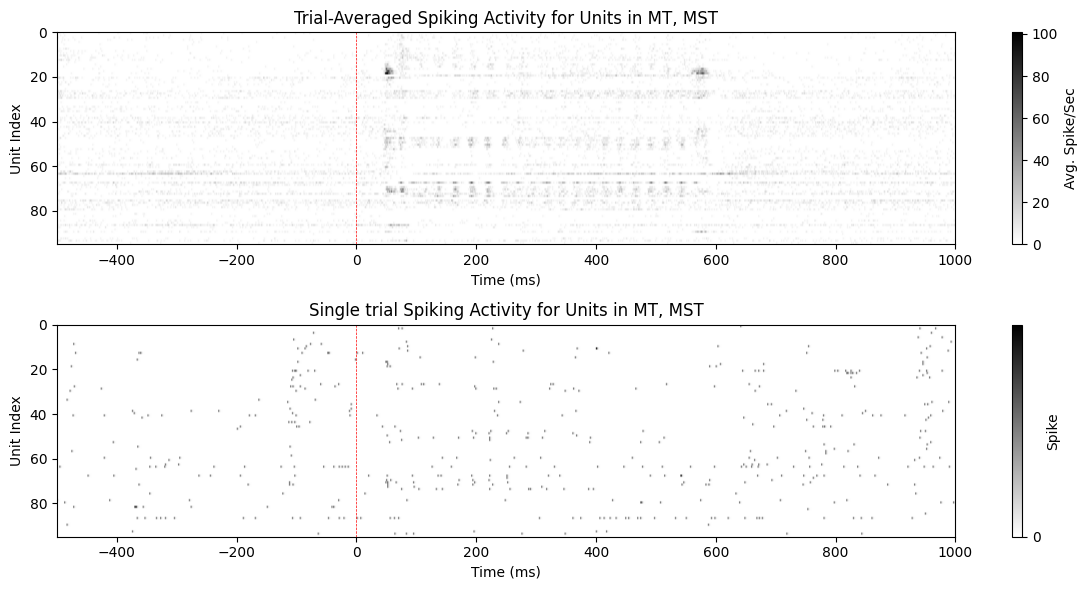

In [ ]:
def get_unit_ids_for_area(nwb_file, target_area_name):
    """
    Retrieves the IDs of units located in a specified brain area from an NWBFile.

    Args:
        nwb_file (pynwb.NWBFile): The NWBFile object containing the units and electrodes data.
        target_area_name (str): The name of the brain area to search for (e.g., "PFC", "V4, MT").

    Returns:
        list: A list of unit IDs that belong to the specified area.
              Returns an empty list if no units are found for the area or if data is missing.
    """
    if nwb_file.units is None or len(nwb_file.units) == 0:
        print("No units table found or it is empty in the NWB file.")
        return []

    if nwb_file.electrodes is None or len(nwb_file.electrodes) == 0:
        print("No electrodes table found or it is empty in the NWB file.")
        return []

    units_df = nwb_file.units.to_dataframe().reset_index() # Make 'id' a column from the index
    # Reset index of electrodes_df to ensure 'id' is a column, not just an index name
    electrodes_df = nwb_file.electrodes.to_dataframe().reset_index()

    # Check for essential columns after ensuring 'id' is a column
    if 'peak_channel_id' not in units_df.columns:
        print("Units table is missing 'peak_channel_id' column.")
        return []
    if 'id' not in electrodes_df.columns:
        print("Error: 'id' column not found in electrodes DataFrame after resetting index. This should not happen.")
        return []

    # Handle 'quality' column existence
    has_quality_column = 'quality' in units_df.columns
    if not has_quality_column:
        print("Warning: 'quality' column not found in units DataFrame. Returning all units in the specified area.")
    else:
        # Convert to float first, then int, to handle '0.0' correctly
        units_df['quality'] = units_df['quality'].astype(float).astype(int)

    # Determine the correct column for area information in electrodes_df
    area_col_name = None
    if 'location' in electrodes_df.columns:
        area_col_name = 'location'
    elif 'label' in electrodes_df.columns:
        area_col_name = 'label'
    else:
        print("Electrodes table is missing 'location' or 'label' column for area information.")
        return []

    # Merge units_df with electrodes_df to get area information for each unit
    # Convert peak_channel_id to int to match electrode_id type
    # Handle cases where peak_channel_id might be float-like strings (e.g., '3.0')
    units_df['peak_channel_id'] = units_df['peak_channel_id'].astype(float).astype(int)

    # Ensure electrode 'id' column is also integer type for consistent merge
    electrodes_df['id'] = electrodes_df['id'].astype(int)

    merged_df = pd.merge(
        units_df,
        electrodes_df[[area_col_name, 'id']],
        left_on='peak_channel_id',
        right_on='id',
        how='left',
        suffixes=('_unit', '_electrode')
    )

    # Normalize area names for comparison (handle bytes and case insensitivity)
    merged_df['area_normalized'] = merged_df[area_col_name].apply(lambda x: x.decode('utf-8').strip().upper() if isinstance(x, bytes) else str(x).strip().upper())
    target_area_name_normalized = target_area_name.strip().upper()

    # Filter units by the target area name and 'quality' status if column exists
    area_filter = (merged_df['area_normalized'] == target_area_name_normalized)

    if has_quality_column:
        good_unit_filter = (merged_df['quality'] == 1)
        final_filter = area_filter & good_unit_filter
    else:
        final_filter = area_filter

    filtered_units = merged_df[final_filter]

    # Return the unit IDs as a list
    return filtered_units['id_unit'].tolist()

area_of_interest = "MT, MST"
unit_ids_in_area = get_unit_ids_for_area(nwb, area_of_interest)

print(f"Unit IDs in '{area_of_interest}': {len(unit_ids_in_area)}")

selected_unit_spiking = single_unit_spiking[:, :, unit_ids_in_area]

# Calculate trial-averaged spiking activity
trial_averaged_spiking = jnp.nanmean(selected_unit_spiking, axis=0) # Shape: (num_timepoints, num_units)
single_trial_spiking = selected_unit_spiking[1, :, :] / jnp.max(selected_unit_spiking[1, :, :])

num_timepoints = trial_averaged_spiking.shape[0]
time_pre_ms = 1000.0 # From original time_pre=1.0s
time_post_ms = 1000.0 # From original time_post=1.0s
time_axis_ms = jnp.linspace(-time_pre_ms, time_post_ms, num_timepoints)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(
    trial_averaged_spiking.T, # Transpose to have units on y-axis, time on x-axis
    aspect='auto',
    cmap='grey_r',
    origin='upper', # Change to 'upper' to have unit index 0 at the top
    extent=[time_axis_ms[0], time_axis_ms[-1], trial_averaged_spiking.shape[1], 0] # Reverse y-extent
)
plt.colorbar(label='Avg. Spike/Sec')
plt.title(f'Trial-Averaged Spiking Activity for Units in {area_of_interest}')
plt.xlabel('Time (ms)')
plt.ylabel('Unit Index')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.5) # Add vertical line at x=0
plt.xlim([-500, 1000])
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.imshow(
    single_trial_spiking.T, # Transpose to have units on y-axis, time on x-axis
    aspect='auto',
    cmap='grey_r',
    origin='upper', # Change to 'upper' to have unit index 0 at the top
    extent=[time_axis_ms[0], time_axis_ms[-1], trial_averaged_spiking.shape[1], 0] # Reverse y-extent
)
plt.colorbar(label='Spike', ticks=[0, 1])
plt.title(f'Single trial Spiking Activity for Units in {area_of_interest}')
plt.xlabel('Time (ms)')
plt.ylabel('Unit Index')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.5) # Add vertical line at x=0
plt.xlim([-500, 1000])
plt.tight_layout()

plt.show()

### Quick loader

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive/')

save_dir = "/content/drive/MyDrive/Workspace/"
file_name = "selected_unit_spiking.npy"
save_path = os.path.join(save_dir, file_name)

# # Save the variable
# jnp.save(save_path, selected_unit_spiking)
# print(f"'selected_unit_spiking' saved to {save_path}")

# Load the variable
selected_unit_spiking = jnp.load(save_path)
print(f"'selected_unit_spiking' loaded from {save_path}")
print(f"Shape of loaded_selected_unit_spiking: {selected_unit_spiking.shape}")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
'selected_unit_spiking' loaded from /content/drive/MyDrive/Workspace/selected_unit_spiking.npy
Shape of loaded_selected_unit_spiking: (40, 2000, 95)


### Functions

In [16]:
import jax.numpy as jnp
import jaxley as jx
import numpy as np

from jaxley.synapses import Synapse
from jaxley.channels import Channel, HH  # Using standard Hodgkin-Huxley for the cell dynamics
import jax
import optax
from flax.struct import dataclass # For GSDR
from typing import Any, Callable, NamedTuple, Optional # For GSDR

import matplotlib.pyplot as plt
from scipy import signal # Import scipy.signal for spectrogram
from scipy import ndimage # Import scipy.ndimage for smoothing


def plot_voltages_as_image(recorded_voltages, time_axis, title="Recorded Voltages as Image", cmap='jet'):
    """
    Plots recorded voltages as a 2D image.

    Args:
        recorded_voltages (jnp.ndarray): Array of shape (num_neurons, num_timepoints).
        time_axis (jnp.ndarray): Array of time points.
        title (str): Title for the plot.
        cmap (str): Colormap to use for the image (default: 'jet').
    """
    plt.figure(figsize=(12, 5))
    # Transpose recorded_voltages to have time on x-axis and neuron index on y-axis
    # Using only the voltage data (excluding the first 'time' column if present in recorded_voltages)
    # If recorded_voltages has shape (num_neurons, num_timepoints + 1) where first col is time,
    # then use recorded_voltages[:, 1:].T
    # Given recorded_voltages.shape is (10, 40001) and time_axis.shape is (40000,),
    # it seems the first element of recorded_voltages for each neuron is V_init or similar,
    # and the time_axis correctly corresponds to the subsequent 40000 points.
    # So we plot recorded_voltages[:, 1:].
    plt.imshow(
        recorded_voltages[:, 1:],
        aspect='auto',
        cmap=cmap,
        origin='lower',
        extent=[time_axis[0], time_axis[-1], 0, recorded_voltages.shape[0]]
    )
    plt.colorbar(label='Voltage (mV)')
    plt.title(title)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron Index')
    plt.show()

def plot_raster(recorded_voltages, time_axis, spike_threshold=-20.0, title='Raster Plot (Spikes > -20mV)'):
    """
    Plots a raster of detected spikes from recorded voltages.

    Args:
        recorded_voltages (jnp.ndarray): Array of shape (num_neurons, num_timepoints).
        time_axis (jnp.ndarray): Array of time points.
        spike_threshold (float):
        title (str): Title for the plot.
    """
    spike_times_list = []
    num_neurons = recorded_voltages.shape[0]

    for i in range(num_neurons):
        # Extract voltage trace for the current neuron, aligning with time_axis
        neuron_trace = recorded_voltages[i, 1:]

        # Detect spikes: voltage crosses threshold from below
        spikes = (neuron_trace[:-1] < spike_threshold) & (neuron_trace[1:] >= spike_threshold)
        spike_indices = jnp.where(spikes)[0]
        spike_times = time_axis[spike_indices]
        spike_times_list.append(spike_times)

    plt.figure(figsize=(12, 5))
    plt.eventplot(spike_times_list, lineoffsets=jnp.arange(num_neurons), linelengths=0.8, color='black')
    plt.title(title)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron Index')
    plt.yticks(jnp.arange(num_neurons))
    plt.ylim(-0.5, num_neurons - 0.5)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_time_frequency_response(recorded_voltages, time_axis, dt_global,
                                 window_size=100.0, overlap=0.9,
                                 f_min=0.5, f_max=100.0, title='Time-Frequency Response (Mean Voltage)', cmap='jet', log_y_scale: bool = False):
    """
    Plots the time-frequency power spectrum (spectrogram) of the mean neuronal potential.

    Args:
        recorded_voltages (jnp.ndarray): Array of shape (num_neurons, num_timepoints).
        time_axis (jnp.ndarray): Array of time points.
        dt_global (float): Global time step in ms.
        window_size (float): Size of the FFT window in ms (default: 100ms).
        overlap (float): Overlap between windows as a fraction (default: 0.9).
        f_min (float): Minimum frequency to display in Hz (default: 0.5Hz).
        f_max (float): Maximum frequency to display in Hz (default: 100Hz).
        title (str): Title for the plot.
        cmap (str): Colormap to use for the spectrogram (default: 'jet').
        log_y_scale (bool): Whether to use a logarithmic scale for the y-axis (frequency) (default: False).
    """
    # 1. Compute the mean neuronal potential signal
    # Exclude the initial voltage value (V_init) at recorded_voltages[:, 0]
    mean_signal = jnp.mean(recorded_voltages[:, 1:], axis=0)

    # Convert JAX numpy array to numpy array for scipy compatibility
    mean_signal_np = np.asarray(mean_signal)
    mean_signal_np = mean_signal_np.astype(np.float64)

    # Smooth the mean_signal_np with a moving mean window of length 10ms
    smoothing_window_samples = int(2.0 / dt_global) # 10ms / 0.1ms = 100 samples
    if smoothing_window_samples > 1:
        mean_signal_np = ndimage.uniform_filter1d(mean_signal_np, size=smoothing_window_samples)

    # 2. Calculate sampling frequency (Hz)
    fs = 1000.0 / dt_global # dt_global is in ms, fs in Hz

    # 3. Spectrogram parameters
    nperseg = int(window_size * fs / 1000.0) # Convert window_size (ms) to samples
    if nperseg == 0: nperseg = 1 # Ensure nperseg is at least 1
    noverlap = int(nperseg * overlap)

    # Ensure noverlap is less than nperseg
    if noverlap >= nperseg:
        noverlap = nperseg - 1
    if noverlap < 0:
        noverlap = 0

    # 4. Compute spectrogram
    frequencies, times, Sxx = signal.spectrogram(mean_signal_np, fs=fs,
                                                 window='hann', nperseg=nperseg,
                                                 noverlap=noverlap)

    # 5. Filter frequencies
    freq_indices = (frequencies >= f_min) & (frequencies <= f_max)
    frequencies_filtered = frequencies[freq_indices]
    Sxx_filtered = Sxx[freq_indices, :]

    # Handle case where no frequencies are in the specified range
    if frequencies_filtered.size == 0:
        print("Warning: No frequencies found within the specified f_min and f_max range.")
        plt.show()
        return

    # Convert to dB scale
    Sxx_log = Sxx_filtered#10 * jnp.log10(Sxx_filtered)

    # Scale Sxx_log to [0, 1]
    min_val = jnp.min(Sxx_log)
    max_val = jnp.max(Sxx_log)
    # Avoid division by zero if all values are identical
    if (max_val - min_val) == 0:
        Sxx_scaled = jnp.zeros_like(Sxx_log)
    else:
        Sxx_scaled = np.sqrt((Sxx_log - min_val) / (max_val - min_val))

    # 6. Plotting
    plt.figure(figsize=(14, 6))
    plt.pcolormesh(times * 1000, frequencies_filtered, Sxx_scaled,
                   cmap=cmap, shading='gouraud')
    plt.colorbar(label='Normalized Power (0-1)') # Label updated to reflect scaling
    plt.title(title)
    plt.xlabel('Time (ms)') # Changed to ms
    plt.ylabel('Frequency (Hz)')

    if log_y_scale:
        plt.yscale('log') # Set y-axis to logarithmic scale

    # New red dashed line values
    red_line_freqs = [3.0, 8.0, 12.0, 20.0, 30.0, 70.0]

    # Combine user-specified base log ticks with red line frequencies and f_max/f_min candidates
    log_ticks_candidate = [1, 3, 10, 30, 100] # User's requested base ticks
    log_ticks_candidate.extend(red_line_freqs)
    log_ticks_candidate.append(f_max)
    log_ticks_candidate.append(f_min) # Ensure f_min is also a candidate for a tick

    # Remove duplicates and sort
    log_ticks = sorted(list(set(log_ticks_candidate)))

    # Filter ticks to be strictly within the actual plotted frequency range
    min_actual_freq = frequencies_filtered[0]
    max_actual_freq = frequencies_filtered[-1]

    if log_y_scale: # Only apply custom log ticks if log_y_scale is true
        log_ticks = [t for t in log_ticks if min_actual_freq <= t <= max_actual_freq]

        # Create tick labels and determine their colors
        tick_labels = []
        tick_label_colors = []
        for t in log_ticks:
            label = str(int(t)) if t >= 1 else f'{t:.1f}'
            tick_labels.append(label)
            if t in red_line_freqs:
                tick_label_colors.append('red')
            else:
                tick_label_colors.append('black')

        ax = plt.gca() # Get current axes
        ax.set_yticks(log_ticks)
        ax.set_yticklabels(tick_labels)

        for i, label in enumerate(ax.get_yticklabels()):
            label.set_color(tick_label_colors[i])

    # Set y-limits to the actual range of filtered frequencies to avoid white space
    plt.ylim([min_actual_freq, max_actual_freq])

    # Add red dashed y-lines for specific frequencies
    # These lines should also respect the *actual plotted* range
    for freq_line in red_line_freqs:
        if min_actual_freq <= freq_line <= max_actual_freq:
            plt.axhline(y=freq_line, color='red', linestyle='--', linewidth=1.5)

    plt.tight_layout()
    plt.show()


class GradedGABAa(Synapse):
    """
    Graded fast Inhibitory Synapse. (GABAa)
    Ref: Golowasch et al. (1999) ; Prinz, A. A., et al. (2004).
    """
    def __init__(self, tauD_GABAa: Optional[float] = None):
        super().__init__()
        self.synapse_params = {
            "gGABAa": 0.05,       # Reduced initial conductance
            "EGABAa": -80.0,     # Reversal Potential (mV)
            "tauDGABAa": 10.0,        # Decay (ms)
            "tauRGABAa": 0.5,         # Rise (ms)
            "slopeGABAa": 5.0,        # Steepness of activation
            "V_thGABAa": -20.0        # Threshold (mV) - Tuned to activate during spikes
        }

        if tauD_GABAa is not None:
            self.synapse_params["tauDGABAa"] = tauD_GABAa

        self.synapse_states = {"sGABAa": 0.01}

    def update_states(self, states, dt, pre_v, post_v, params):
        # s' = -s/tauD + 0.5*(1+tanh((V-Vth)/slope)) * ((1-s)/tauR)
        s = states["sGABAa"]
        activation = 0.5 * (1 + jnp.tanh((pre_v - params["V_thGABAa"]) / params["slopeGABAa"]))
        d_s = (-s / params["tauDGABAa"]) + activation * ((1 - s) / params["tauRGABAa"])
        return {"sGABAa": s + d_s * dt}

    def compute_current(self, states, pre_v, post_v, params):
        return params["gGABAa"] * states["sGABAa"] * (post_v - params["EGABAa"])


class GradedGABab(Synapse):
    """
    Graded slow Inhibitory Synapse. (GABab)
    Ref: Golowasch et al. (1999) ; Prinz, A. A., et al. (2004).
    """
    def __init__(self, tauD_GABab: Optional[float] = None):
        super().__init__()
        self.synapse_params = {
            "gGABab": 0.05,       # Conductance (uS)
            "EGABab": -95.0,     # Reversal Potential (mV)
            "tauDGABab": 200.0,        # Decay (ms)
            "tauRGABab": 10.0,         # Rise (ms)
            "slopeGABab": 5.0,        # Steepness of activation
            "V_thGABab": -20.0        # Threshold (mV) - Tuned to activate during spikes
        }

        if tauD_GABab is not None:
            self.synapse_params["tauDGABab"] = tauD_GABab

        self.synapse_states = {"sGABab": 0.001}

    def update_states(self, states, dt, pre_v, post_v, params):
        # s' = -s/tauD + 0.5*(1+tanh((V-Vth)/slope)) * ((1-s)/tauR)
        s = states["sGABab"]
        activation = 0.5 * (1 + jnp.tanh((pre_v - params["V_thGABab"]) / params["slopeGABab"]))
        d_s = (-s / params["tauDGABab"]) + activation * ((1 - s) / params["tauRGABab"])
        return {"sGABab": s + d_s * dt}

    def compute_current(self, states, pre_v, post_v, params):
        return params["gGABab"] * states["sGABab"] * (post_v - params["EGABab"])


class GradedAMPA(Synapse):
    """
    Graded Excitatory Synapse.
    Same dynamics as GradedGABAa, but with E_rev = 0 mV and faster kinetics.
    """
    def __init__(self, tauD_AMPA: Optional[float] = None):
        super().__init__()
        self.synapse_params = {
            "gAMPA": 0.01,       # Reduced initial conductance
            "EAMPA": 0.0,        # Reversal Potential (mV) - EXCITATORY
            "tauDAMPA": 5.0,         # Faster decay for AMPA
            "tauRAMPA": 0.2,         # Fast rise
            "slopeAMPA": 5.0,
            "V_thAMPA": -20.0        # Threshold (mV)
        }

        if tauD_AMPA is not None:
            self.synapse_params["tauDAMPA"] = tauD_AMPA

        self.synapse_states = {"sAMPA": 0.01}

    def update_states(self, states, dt, pre_v, post_v, params):
        s = states["sAMPA"]
        # Using same naming convention for internal params, mapped to AMPA
        activation = 0.5 * (1 + jnp.tanh((pre_v - params["V_thAMPA"]) / params["slopeAMPA"]))
        d_s = (-s / params["tauDAMPA"]) + activation * ((1 - s) / params["tauRAMPA"])
        return {"sAMPA": s + d_s * dt}

    def compute_current(self, states, pre_v, post_v, params):
        return params["gAMPA"] * states["sAMPA"] * (post_v - params["EAMPA"])


class Inoise(Channel):
    """
    Stochastic Ornstein-Uhlenbeck noise channel.
    """
    def __init__(self, name: str = None, initial_seed: Optional[int] = None, initial_amp_noise: Optional[float] = None, initial_tau: Optional[float] = None):
        self.current_is_in_mA_per_cm2 = True
        super().__init__(name)

        self.channel_params = {
            "amp_noise": 0.0005,  # Reduced initial noise amplitude
            "mean": 0.0,        # The baseline current drive [mA/cm^2]
            "tau": 50.0         # Correlation time constant [ms]
        }
        # If no initial_seed is provided, generate a random one using numpy.
        # This ensures each Inoise instance gets a unique starting seed.
        if initial_seed is None:
            self.channel_params["seed"] = float(np.random.randint(0, 2**16 - 1))
        else:
            self.channel_params["seed"] = float(initial_seed)

        if initial_amp_noise is None:
            self.channel_params["amp_noise"] = float(0.0005) # Ensure this default is also reduced
        else:
            self.channel_params["amp_noise"] = float(initial_amp_noise)

        if initial_tau is None:
            self.channel_params["tau"] = float(40.0)
        else:
            self.channel_params["tau"] = float(initial_tau)

        self.channel_states = {"n": 0.00, "step": 0.0}
        self.current_name = "i_noise"

    def update_states(self, states, dt, v, params):
        """
        Updates the noise state 'n' using an Ornstein-Uhlenbeck process.
        """
        n = states["n"]
        step = states["step"]

        # 1. RNG Handling
        # When JAXley vmaps the update_states function, params["seed"] will be an array.
        # All other inputs (n, step, v, dt) will also be batched (arrays).
        # We need to vmap the PRNGKey and fold_in calls.

        # Ensure seed is an integer type for PRNGKey
        seeds_int = params["seed"].astype(int)

        # Create base keys (potentially batched)
        if seeds_int.ndim == 0:
            base_key = jax.random.PRNGKey(seeds_int)
        else:
            base_key = jax.vmap(jax.random.PRNGKey)(seeds_int)

        # Fold in step (potentially batched)
        if step.ndim == 0:
            step_key = jax.random.fold_in(base_key, step.astype(int))
        else: # if step is an array
            step_key = jax.vmap(jax.random.fold_in)(base_key, step.astype(int))

        # Generate normal random numbers (potentially batched)
        # A single JAX PRNGKey has shape (2,) and ndim=1.
        # An array of N JAX PRNGKeys has shape (N, 2) and ndim=2.
        if step_key.ndim == 1: # if step_key is a single key
            xi = jax.random.normal(step_key)
        else: # if step_key is an array of keys (ndim 2 for key array)
            xi = jax.vmap(jax.random.normal)(step_key)

        # 2. Physics (Ornstein-Uhlenbeck)
        # dn = -(n - mean)/tau * dt + sigma*sqrt(2/tau)*dW
        mu = params["mean"]
        sigma = params["amp_noise"]
        tau = params["tau"]

        drift = (mu - n) / tau * dt
        diffusion = sigma * jnp.sqrt(2.0 / tau) * xi * jnp.sqrt(dt)

        new_n = n + drift + diffusion

        # Return new state AND increment step
        return {"n": new_n, "step": step + 1.0}

    def compute_current(self, states, v, params):
        """
        Returns the current.
        Note: We return negative 'n' so that a positive mean acts
        as an excitatory (depolarizing) injection in the cable equation.
        """
        return -states["n"]

    def init_state(self, states, v, params, delta_t):
        """
        Initialize to the mean value.
        This needs to handle batched parameters if JAXley vmaps init_state.
        """
        # If params["mean"] is a scalar, jnp.zeros_like(params["mean"]) is a scalar 0.0.
        # If params["mean"] is an array, jnp.zeros_like(params["mean"]) is an array of 0.0s.
        # This handles both cases correctly.
        return {"n": jnp.zeros_like(params["mean"]) + params["mean"], "step": jnp.zeros_like(params["mean"]) + 0.0}


class Dataset:
    """A simple Dataloader which returns batches of the data.

    Instead of using this simple dataloader, you can also just use one from
    PyTorch or Tensorflow. You do not have to understand what is going on here
    to follow this tutorial.
    """

    def __init__(self, inputs: np.ndarray, labels: np.ndarray):
        """
        Initialize the dataloader.

        Args:
            inputs: Array of shape (num_samples, num_dim)
            labels: Array of shape (num_samples,)
        """
        assert len(inputs) == len(labels), "Inputs and labels must have same length"
        self.inputs = inputs
        self.labels = labels
        self.num_samples = len(inputs)
        self._rng_state = None
        self.batch_size = 1

    def shuffle(self, seed=None):
        """
        Shuffle the dataset in-place
        """
        self._rng_state = np.random.get_state()[1][0] if seed is None else seed
        np.random.seed(self._rng_state)
        indices = np.random.permutation(self.num_samples)
        self.inputs = self.inputs[indices]
        self.labels = self.labels[indices]
        return self

    def batch(self, batch_size):
        """
        Create batches of the data.
        """
        self.batch_size = batch_size
        return self

    def __iter__(self):
        """
        Iterate over the dataset.
        """
        self.shuffle(seed=self._rng_state)
        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            yield self.inputs[start:end], self.labels[start:end]
        self._rng_state += 1


@dataclass
class GSDRState:
    inner_state: Any
    params_opt: Any
    inner_state_opt: Any
    loss_opt: float
    a: float
    a_opt: float
    lambda_d: float
    step_count: int  # Current optimization step/epoch
    consecutive_unchanged_epochs: int  # How many steps loss_opt hasn't improved
    last_optimal_change_step: int  # Step count of last loss_opt improvement or checkpoint load


def GSDR(
    inner_optimizer: optax.GradientTransformation,
    delta_distribution: Callable = jax.random.normal,
    deselection_threshold: float = 2.0,
    a_init: float = 0.5,
    lambda_d: float = 1.0,
    a_dynamic: bool = True,
    checkpoint_n: int = 10,  # New parameter
    tau_a_growth: float = 5.0 # New parameter for 'a' dynamics recovery
) -> optax.GradientTransformation:
    """
    Optax-compliant implementation of the Genetic-Stochastic Delta Rule.
    """

    def init_fn(params):
        inner_state = inner_optimizer.init(params)
        return GSDRState(
            inner_state=inner_state,
            params_opt=params,
            inner_state_opt=inner_state,
            loss_opt=jnp.inf,
            a=a_init,
            a_opt=a_init,
            lambda_d=lambda_d,
            step_count=0,
            consecutive_unchanged_epochs=0,
            last_optimal_change_step=0
        )

    def update_fn(updates, state, params=None, value=None, key=None):
        if params is None:
            raise ValueError("GSDR requires 'params' to be passed to update().")
        if value is None:
            raise ValueError("GSDR requires current loss 'value' to be passed to update().")
        if key is None:
            raise ValueError("GSDR requires a random 'key' to be passed to update().")

        grads = updates
        loss = value

        # Increment step count
        current_step = state.step_count + 1

        delta_key, a_key = jax.random.split(key)

        # Determine if a new optimal state is found
        # Reverted to original logic: only save if loss is strictly better and not NaN
        is_new_opt = (loss < state.loss_opt)

        # Update optimal parameters and loss
        new_params_opt = jax.tree.map(
            lambda cur, opt: jnp.where(is_new_opt, cur, opt),
            params, state.params_opt
        )
        new_loss_opt = jnp.where(is_new_opt, loss, state.loss_opt)
        new_a_opt = jnp.where(is_new_opt, state.a, state.a_opt)
        new_inner_state_opt = jax.tree.map(
            lambda cur, opt: jnp.where(is_new_opt, cur, opt),
            state.inner_state, state.inner_state_opt
        )

        # Track consecutive epochs where loss_opt hasn't improved
        next_consecutive_unchanged_epochs = jnp.where(
            is_new_opt,
            0, # Reset counter if new optimal found
            state.consecutive_unchanged_epochs + 1
        )

        # Update last_optimal_change_step if a new optimal is found
        step_of_last_optimal_change = jnp.where(
            is_new_opt,
            current_step, # Record current step as time of optimal change
            state.last_optimal_change_step
        )

        # Check for deselection condition (loss deteriorated significantly)
        # This still includes the check for NaN loss, correctly triggering a reset.
        is_deselect = ((loss > (new_loss_opt * deselection_threshold)) & (new_loss_opt != jnp.inf)) | (jnp.isnan(loss))

        # Check for checkpoint condition (loss hasn't improved for checkpoint_n steps)
        # Only trigger if current_step is at least checkpoint_n and optimal loss is not inf
        is_reset_due_to_checkpoint = (current_step > 0) & (next_consecutive_unchanged_epochs >= checkpoint_n) & (new_loss_opt != jnp.inf)

        # Determine if a reset to the stored optimal state should occur (either by deselection or checkpoint)
        should_reset_to_opt_state = is_deselect | is_reset_due_to_checkpoint

        # Final consecutive_unchanged_epochs and last_optimal_change_step for the next state
        # If reset due to checkpoint, these counters should also be reset/updated
        final_consecutive_unchanged_epochs = jnp.where(
            is_reset_due_to_checkpoint,
            0, # Reset counter after loading optimal
            next_consecutive_unchanged_epochs
        )
        final_last_optimal_change_step = jnp.where(
            is_reset_due_to_checkpoint,
            current_step, # Update to current step as a new starting point for 'a' dynamics
            step_of_last_optimal_change # Otherwise, use step from new optimal
        )

        # Determine 'a' for this step, with dynamic perturbation
        if a_dynamic:
            time_since_last_change = current_step - final_last_optimal_change_step
            time_since_last_change = jnp.maximum(0, time_since_last_change) # Ensure non-negative

            # Calculate effective lambda_d: starts small after a change/reset, gradually increases
            # tau_a_growth is captured from GSDR constructor.
            effective_lambda_d = state.lambda_d * (1.0 - jnp.exp(-time_since_last_change / tau_a_growth))

            delta_a = jax.random.uniform(a_key, minval=-effective_lambda_d, maxval=effective_lambda_d)
            a_candidate = state.a + delta_a
            # User's original 'a_random' calculation from tanh function
            a_random = jax.nn.tanh(a_candidate - 0.5)/2 + 0.5

            # If reset is needed (due to deselection or checkpoint), 'a' should revert to its optimal value. |
            # Otherwise, it's the randomly perturbed 'a_random'.
            next_a = jnp.where(should_reset_to_opt_state, new_a_opt, a_random)
        else:
            next_a = state.a # 'a' is constant if a_dynamic is False


        # Decide which inner state to use for the inner_optimizer.update call
        # If reset is needed, use the optimal inner state; otherwise, continue with current
        inner_state_for_update = jax.tree.map(
            lambda opt_st, cur_st: jnp.where(should_reset_to_opt_state, opt_st, cur_st),
            new_inner_state_opt, state.inner_state
        )

        inner_updates, updated_inner_state = inner_optimizer.update(grads, inner_state_for_update, params)

        # Calculate delta noise
        param_leaves, treedef = jax.tree_util.tree_flatten(params)
        subkeys = jax.random.split(delta_key, len(param_leaves))
        param_keys_tree = jax.tree.unflatten(treedef, subkeys)

        delta_noise = jax.tree.map(
            lambda p, k: delta_distribution(k, p.shape), # Removed `loss *` as it was causing issues.
            params, param_keys_tree
        )
        delta = jax.tree.map(lambda n, p: n * p, delta_noise, params)

        combined_updates = jax.tree.map(
            lambda d, g: next_a * d + (1 - next_a) * g,
            delta, inner_updates
        )

        # Apply updates based on whether a reset occurred.
        # If reset, the updates should effectively revert params to new_params_opt
        reset_updates = jax.tree.map(
            lambda opt_p, cur_p: opt_p - cur_p,
            new_params_opt, params
        )

        final_updates = jax.tree.map(
            lambda reset_upd, calc_upd: jnp.where(should_reset_to_opt_state, reset_upd, calc_upd),
            reset_updates, combined_updates
        )

        # Final inner state: if reset, use new_inner_state_opt, else use updated_inner_state
        final_updated_inner_state = jax.tree.map(
            lambda reset_st, advanced_st: jnp.where(should_reset_to_opt_state, reset_st, advanced_st),
            new_inner_state_opt, updated_inner_state
        )


        new_state = GSDRState(
            inner_state=final_updated_inner_state,
            params_opt=new_params_opt,
            inner_state_opt=new_inner_state_opt,
            loss_opt=new_loss_opt,
            a=next_a,
            a_opt=new_a_opt,
            lambda_d=state.lambda_d,
            step_count=current_step,
            consecutive_unchanged_epochs=final_consecutive_unchanged_epochs,
            last_optimal_change_step=final_last_optimal_change_step
        )

        return final_updates, new_state

    return optax.GradientTransformation(init_fn, update_fn)


def noise_current(i_delay: float, i_dur: float, i_amp: float, delta_t: float, t_max: float, seed: int = 0) -> jnp.ndarray:
    """
    Generates a random noise current pulse using an Ornstein-Uhlenbeck process.

    Args:
        i_delay: Start time of the current pulse in ms.
        i_dur: Duration of the current pulse in ms.
        i_amp: Overall amplitude scaling of the noise pulse (nA).
        delta_t: Time step for the simulation in ms.
        t_max: Total simulation time in ms.
        seed: Random seed for reproducibility (default: 0).

    Returns:
        jnp.ndarray: Array representing the noise current pulse over time, with shape (int(t_max / delta_t) + 1,).R
    """
    # Parameters for the Ornstein-Uhlenbeck noise process
    noise_standard_deviation = 0.01 # Sigma for OU (nA) - a default value
    noise_correlation_tau = 20.0     # Correlation time in ms
    noise_mean = 0.0                 # Mean of the OU process

    key = jax.random.PRNGKey(seed)

    # Calculate number of steps to include initial state (for JAXley compatibility)
    num_steps = int(t_max / delta_t) + 1
    time_axis_array = jnp.arange(0, t_max + delta_t, delta_t)

    def ou_step_fn(n_prev, key_t):
        key_noise, _ = jax.random.split(key_t)
        xi = jax.random.normal(key_noise)

        drift = (noise_mean - n_prev) / noise_correlation_tau * delta_t
        diffusion = noise_standard_deviation * jnp.sqrt(2.0 / noise_correlation_tau) * xi * jnp.sqrt(delta_t)

        new_n = n_prev + drift + diffusion # FIX: Changed 'n' to 'n_prev'

        # Return new state AND increment step
        return new_n, new_n

    initial_state_ou = noise_mean
    # Split keys for num_steps-1 iterations, as initial_state is already handled
    keys_series = jax.random.split(key, num_steps - 1)

    # Run the scan to generate the raw noise trace
    _, full_noise_trace_raw = jax.lax.scan(ou_step_fn, initial_state_ou, keys_series)
    # Prepend the initial state to get the full trace length
    full_noise_trace = jnp.concatenate([jnp.array([initial_state_ou]), full_noise_trace_raw])

    # Apply the pulse window based on i_delay and i_dur
    time_off = i_delay + i_dur
    pulse_mask = (time_axis_array >= i_delay) & (time_axis_array <= time_off)

    # Scale the noise by i_amp and apply the pulse mask
    noise_current_pulse_array = jnp.where(pulse_mask, full_noise_trace * i_amp, 0.0)

    return noise_current_pulse_array


def plot_full_simulation_summary(recorded_voltages, time_axis, dt_global,
                                 spike_threshold=-20.0,
                                 window_size=250.0, overlap=0.95,
                                 f_min=1.0, f_max=100.0,
                                 title_suffix=""):
    """
    Combines voltage image, raster plot, and time-frequency response into a single 3x1 subplot figure.
    """
    plt.figure(figsize=(12, 18)) # Adjust figure size for 3 tall subplots

    # Subplot 1: Voltages as Image
    plt.subplot(3, 1, 1)
    plt.imshow(
        recorded_voltages[:, 1:],
        aspect='auto',
        cmap='jet',
        origin='lower',
        extent=[time_axis[0], time_axis[-1], 0, recorded_voltages.shape[0]]
    )
    plt.colorbar(label='Voltage (mV)')
    plt.title(f'Recorded Voltages as Image {title_suffix}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron Index')
    plt.xlim([time_axis[0], time_axis[-1]])
    plt.axvline(x=500, color='red', linestyle='--', linewidth=0.5)

    # Subplot 2: Raster Plot
    plt.subplot(3, 1, 2)
    spike_times_list = []
    num_neurons = recorded_voltages.shape[0]

    for i in range(num_neurons):
        neuron_trace = recorded_voltages[i, 1:]
        spikes = (neuron_trace[:-1] < spike_threshold) & (neuron_trace[1:] >= spike_threshold)
        spike_indices = jnp.where(spikes)[0]
        spike_times = time_axis[spike_indices]
        spike_times_list.append(spike_times)

    plt.eventplot(spike_times_list, lineoffsets=jnp.arange(num_neurons), linelengths=0.8, color='black')
    plt.title(f'Raster Plot (Spikes > {spike_threshold}mV) {title_suffix}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron Index')
    plt.yticks(jnp.arange(num_neurons))
    plt.ylim(-0.5, num_neurons - 0.5)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlim([time_axis[0], time_axis[-1]])
    plt.axvline(x=500, color='red', linestyle='--', linewidth=0.5)

    # Subplot 3: Time-Frequency Response
    plt.subplot(3, 1, 3)
    mean_signal = jnp.mean(recorded_voltages[:, 1:], axis=0)
    mean_signal_np = np.asarray(mean_signal)
    mean_signal_np = mean_signal_np.astype(np.float64)

    # Replace NaN or Inf values with 0
    mean_signal_np = np.nan_to_num(mean_signal_np, nan=0.0, posinf=0.0, neginf=0.0)

    smoothing_window_samples = int(2.0 / dt_global)
    if smoothing_window_samples > 1:
        mean_signal_np = ndimage.uniform_filter1d(mean_signal_np, size=smoothing_window_samples)

    fs = 1000.0 / dt_global
    nperseg = int(window_size * fs / 1000.0) # FIX: Removed extra '*'
    if nperseg == 0: nperseg = 1
    noverlap = int(nperseg * overlap)
    if noverlap >= nperseg: noverlap = nperseg - 1
    if noverlap < 0:
        noverlap = 0

    frequencies, times, Sxx = signal.spectrogram(mean_signal_np, fs=fs,
                                                 window='hann', nperseg=nperseg,
                                                 noverlap=noverlap)

    freq_indices = (frequencies >= f_min) & (frequencies <= f_max)
    frequencies_filtered = frequencies[freq_indices]
    Sxx_filtered = Sxx[freq_indices, :]

    if frequencies_filtered.size == 0:
        print("Warning: No frequencies found within the specified f_min and f_max range for spectrogram in combined plot.")
    else:
        min_val = jnp.min(Sxx_filtered)
        max_val = jnp.max(Sxx_filtered)
        Sxx_scaled = (Sxx_filtered - min_val) / (max_val - min_val) if (max_val - min_val) != 0 else jnp.zeros_like(Sxx_filtered)

        plt.pcolormesh(times * 1000, frequencies_filtered, Sxx_scaled,
                       cmap='jet', shading='gouraud')
        plt.colorbar(label='Normalized Power (0-1)')
        plt.title(f'Mean Neuronal Potential Time-Frequency Response {title_suffix}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Frequency (Hz)')
        plt.ylim([frequencies_filtered[0], frequencies_filtered[-1]])
        plt.xlim([time_axis[0], time_axis[-1]])
        plt.axvline(x=500, color='red', linestyle='--', linewidth=0.5)
        red_line_freqs = [3.0, 8.0, 12.0, 20.0, 30.0, 70.0]
        for freq_line in red_line_freqs:
            if frequencies_filtered[0] <= freq_line <= frequencies_filtered[-1]:
                plt.axhline(y=freq_line, color='red', linestyle='--', linewidth=1.5)

    plt.tight_layout()
    plt.show()


## Model structure and data

### Excitatory-Inhibitory network model

In [6]:
def net_eig(num_e: int, num_ig: int, num_il: int):
    """
    Constructs a JAXley neural network with specified numbers of excitatory and inhibitory neurons.

    Args:
        num_e (int): Number of Excitatory neurons.
        num_ig (int): Number of Global inhibitory interneurons (SST-like).
        num_il (int): Number of Local inhibitory interneurons (PV-like).

    Returns:
        jx.Network: The constructed JAXley network object.
    """
    comp = jx.Compartment()
    branch = jx.Branch(comp, ncomp=2)

    e_cells = [jx.Cell(branch, parents=[-1, 0]) for _ in range(num_e)]
    i_cells_g = [jx.Cell(branch, parents=[-1, 0]) for _ in range(num_ig)]
    i_cells_l = [jx.Cell(branch, parents=[-1, 0]) for _ in range(num_il)]

    # Note: cnte logic removed as it's not strictly necessary inside the loop
    # and initial_amp_noise can be set directly based on cell type if needed.
    # For now, uniform noise amp for all cells as per previous state.
    for cell in e_cells + i_cells_g + i_cells_l:
        cell.insert(HH())
        cell.insert(Inoise(initial_amp_noise=0.015, initial_tau=10.0))
        cell.radius = 10.0  #  geometry for excitability
        cell.length = 10.0

    # 2. Define the Network
    net = jx.Network(e_cells + i_cells_g + i_cells_l)

    # 3. Connectivity (All-to-All between populations)

    # E -> E (AMPA)
    pre = net.cell([ik for ik in range(num_e)]).branch(0).loc(0.0)
    post = net.cell([ik for ik in range(num_e)]).branch(1).loc(1.0)
    fully_connect(pre, post, GradedAMPA(tauD_AMPA=25.0))

    # E -> I (AMPA)
    pre = net.cell([ik for ik in range(num_e)]).branch(0).loc(0.0)
    post = net.cell([ik for ik in range(num_e, num_e+num_ig+num_il)]).branch(1).loc(1.0)
    fully_connect(pre, post, GradedAMPA(tauD_AMPA=25.0))

    # Ig -> E (GABAa)
    pre = net.cell([ik for ik in range(num_e, num_e+num_ig)]).branch(0).loc(0.0)
    post = net.cell([ik for ik in range(num_e)]).branch(1).loc(1.0)
    fully_connect(pre, post, GradedGABAa(tauD_GABAa=25.0))

    # Il -> subset of (E + Ig + Il) (GABAa)
    pre_il = net.cell([ik for ik in range(num_e+num_ig, num_e+num_ig+num_il)]).branch(0).loc(0.0)

    # Define the pool of possible postsynaptic neurons (indices 0 to 50)
    num_posts_to_select = 10
    posts_pool_indices = jnp.arange(0, num_e + num_ig + num_il - 1) # Adjust range to avoid exceeding total cells
    key_conn = jax.random.PRNGKey(5678)
    selected_post_indices = np.array(jax.random.choice(key_conn, posts_pool_indices, shape=(num_posts_to_select,), replace=False))
    post_il = net.cell(selected_post_indices).branch(1).loc(1.0)

    # Connect all presynaptic Il cells to this selected subset of postsynaptic cells
    fully_connect(pre_il, post_il, GradedGABAa(tauD_GABAa=25.0))

    net.insert(Leak())

    # net.compute_xyz()
    # net.rotate(180)
    # net.arrange_in_layers(layers=[num_e, num_ig + num_il], within_layer_offset=100.0, between_layer_offset=200.0)
    # fig, ax = plt.subplots(1, 1, figsize=(6, 12))
    # _ = net.vis(ax=ax, detail="full")

    return net


### Data holder

In [ ]:
from scipy import ndimage


def get_signal_psd(traces, fs=1000):
  signal = jnp.nanmean(jnp.squeeze(traces), axis=1) # Average voltage across all recorded neurons over time
  # signal = ndimage.uniform_filter1d(signal, size=10)
  N = signal.shape[-1]

  # Compute one-sided FFT and corresponding frequencies for real signals
  signal_fft = jnp.fft.rfft(signal)
  freqs = jnp.fft.rfftfreq(N, 1/fs)
  psd_raw = jnp.abs(signal_fft)**2 / (N * fs)

  target_freqs = jnp.linspace(1.0, 100.0, 100)
  interpolated_psd = jnp.interp(target_freqs, freqs, psd_raw)
  interpolated_psd = ndimage.uniform_filter1d(interpolated_psd, size=jnp.ceil(5*jnp.sqrt(fs/1000)).astype(int))

  max_psd = jnp.max(interpolated_psd)
  scaled_psd = interpolated_psd / (max_psd + 1e-6)
  return scaled_psd


inputs = jnp.array([0.0, 0.0, 0.0, 1.0, 1.0, 1.0]) # nA stim amp for the three groups
labels = jnp.zeros((6, 100))

for ik in range(3):
  base_units_spectrum = get_signal_psd(selected_unit_spiking[0, :1000, :])
  labels = labels.at[ik].set(base_units_spectrum)

for ik in range(3, 6):
  stim_units_spectrum = get_signal_psd(selected_unit_spiking[5, 500:1500, :])
  labels = labels.at[ik].set(stim_units_spectrum)

batch_size = 3
dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(batch_size)

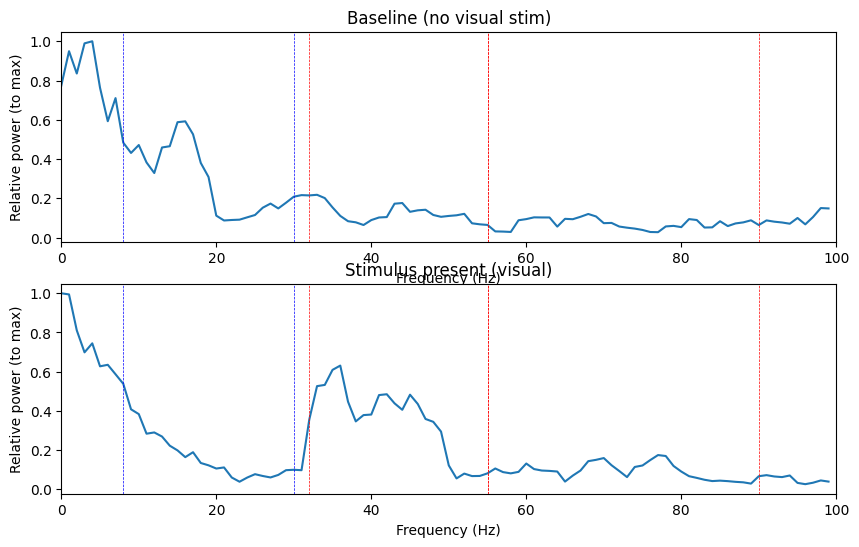

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(base_units_spectrum)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Baseline (no visual stim)')
plt.xlim([0, 100])

plt.subplot(2, 1, 2)
plt.plot(stim_units_spectrum)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Stimulus present (visual)')
plt.xlim([0, 100])

plt.show()

## Optimizer

### Objective and loss configuration

In [ ]:
dt_global = 0.1
t_max_global = 1500

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
net = net_eig(Ne, Nig, Nil)

gAMPA_lower_bounds = 0.00
gAMPA_upper_bounds = 1.00

gGABA_lower_bounds = 0.00
gGABA_upper_bounds = 1.00

# Correctly define transform as ParamTransform for the entire parameter tree
transform = jx.ParamTransform([
    {"gAMPA": jt.SigmoidTransform(gAMPA_lower_bounds, gAMPA_upper_bounds)},
    {"gGABAa": jt.SigmoidTransform(gGABA_lower_bounds, gGABA_upper_bounds)}
])

net.delete_stimuli()
net.delete_trainables()
net.GradedAMPA.edge("all").make_trainable("gAMPA")
net.GradedGABAa.edge("all").make_trainable("gGABAa")

levels = 2
# Recalculate time_points and checkpoints due to dt change
time_points = t_max_global / dt_global + 1 # 100.0 / 0.005 + 1 = 20000 + 1 = 20001
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

# Ensure recordings are set up for the network if not already done in the model definition
# This ensures that `integrate` captures the necessary neuron activities.
net.delete_recordings()
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()


def simulate(params, input_amp):
    """
    Simulates the network for a given scalar input amplitude.
    The input_amp is a scalar (single stimulus amplitude for a batch item).
    This simulate function is designed for the PSD fitting task.
    """
    # Create currents for a single cell (e.g., cell 0)
    current_amp_nA = input_amp # Assuming input_amp is already in nA, used directly.
    currents = noise_current(
        i_delay=500.0, i_dur=500.0,
        i_amp=current_amp_nA,
        delta_t=dt_global,
        t_max=t_max_global
    )
    # currents = jx.datapoint_to_step_currents(
    #     i_delay=500.0,  # Delay before stimulus starts (ms)
    #     i_dur=500.0,    # Duration of stimulus (ms)
    #     i_amp=[current_amp_nA], # Wrapped in a list to satisfy jx.datapoint_to_step_currents expected input
    #     delta_t=dt,
    #     t_max=t_max
    # )

    # Stimulate cell 0. If multiple cells need stimulation per input,
    # the 'input_amp' would need to be an array of amplitudes or a function of the cell index.
    # FIX: Pass the entire time series 'currents' to data_stimulate, not just currents[0]
    # FIX: Change branch(2) to branch(1) as branch(2) does not exist in current network definition
    data_stimuli = net.cell([ik for ik in range(Ne)]).branch(0).loc(0.0).data_stimulate(currents)

    # Integrate the network dynamics.
    # `traces` will be of shape (num_recorded_nodes, num_timepoints).
    # num_timepoints will be `t_max / dt + 1` if V_init is included.
    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

# Batch the simulate function for multiple input amplitudes
batched_simulate = vmap(simulate, in_axes=(None, 0))


def predict(params, input_amp):
    """
    Predicts a scaled PSD array of shape (100,) for frequencies from 1Hz to 100Hz.
    This function processes a single simulation result (from a scalar input_amp).
    """
    traces = simulate(params, input_amp)  # Shape `(num_recorded_nodes, num_timepoints)`

    # Exclude the initial voltage value (V_init) at traces[:, 0]
    # The `integrate` function typically returns the initial state as the first time point.
    # So the actual time series data starts from index 1.
    signal = jnp.mean(traces[:, 1:], axis=0) # Average voltage across all recorded neurons over time

    N = signal.shape[-1] # Number of time points for PSD calculation (t_max / dt = 20000)
    fs = 1000.0 / dt_global         # Sampling frequency (1Hz / 0.1ms = 10KHz)

    # Compute one-sided FFT and corresponding frequencies for real signals
    signal_fft = jnp.fft.rfft(signal)
    freqs = jnp.fft.rfftfreq(N, d=dt_global/1000)

    # Compute Power Spectral Density
    # P_xx(f) = (1 / (N*fs)) * |X(f)|^2
    # Where X(f) is the FFT of x(t)
    psd_raw = jnp.abs(signal_fft)**2 / (N * fs)

    # Target frequencies for the output (1Hz to 100Hz, 100 points)
    target_freqs = jnp.linspace(1.0, 100.0, 100)

    # Interpolate PSD values at target_freqs
    # jnp.interp handles values outside the `freqs` range by clamping to boundary values.
    # With dt=0.005, freqs will go up to 100Hz, so all target_freqs are within range.
    interpolated_psd = jnp.interp(target_freqs, freqs, psd_raw)

    # Scale the PSD array (normalize by its maximum value)
    # This helps ensure consistency if labels are also normalized, and prevents very large/small loss values.
    # Add a small epsilon to avoid division by zero if all PSD values are zero.
    max_psd = jnp.max(interpolated_psd)
    scaled_psd = interpolated_psd / (max_psd + 1e-6)

    # Ensure shape (100,)
    return scaled_psd


# Batch the predict function for multiple input amplitudes (from the 'inputs' array)
batched_predict = vmap(predict, in_axes=(None, 0))


def loss(opt_params, inputs, labels):
    """
    Loss function for PSD fitting.
    opt_params: optimized network parameters (in transformed space)
    inputs: batch of scalar stimulus amplitudes (shape: (batch_size,))
    labels: batch of target PSD arrays (shape: (batch_size, 100))
    """
    params = transform.forward(opt_params) # Convert optimized params back to original space

    predictions = batched_predict(params, inputs) # Shape (batch_size, 100)

    # sum of square of log of predictions-labels.
    # It should be always positive, and close to 0 if each prediction is equal to the label*
    epsilon = 1e-6 # Small epsilon for numerical stability
    losses_per_sample = jnp.sum(jnp.square(jnp.log((predictions + epsilon) / (labels + epsilon))), axis=1)

    return jnp.mean(losses_per_sample) # Average loss across the batch


# JIT the loss function and its gradient for efficiency
jitted_grad = jit(value_and_grad(loss, argnums=0))

Number of newly added trainable parameters: 1800. Total number of trainable parameters: 1800
Number of newly added trainable parameters: 322. Total number of trainable parameters: 2122
Added 50 recordings. See `.recordings` for details.


Visualzation

Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 2.00 nA...
Post-training simulation completed. Recorded voltages shape: (50, 15002)


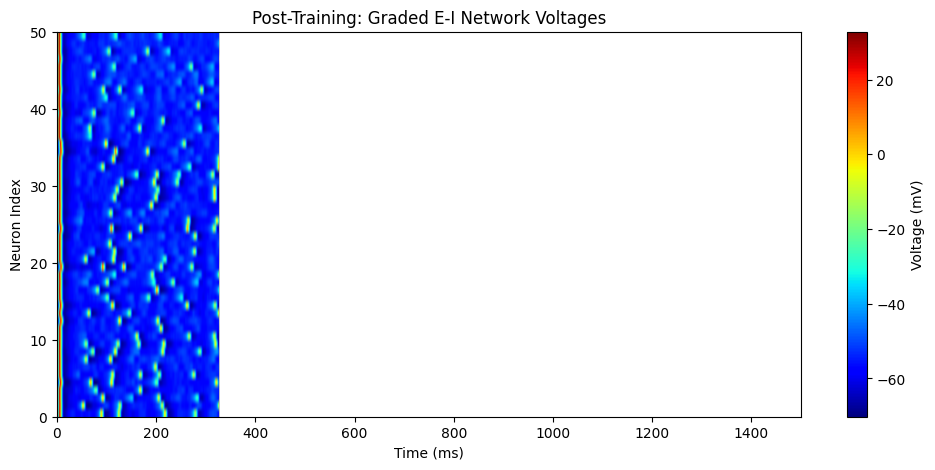

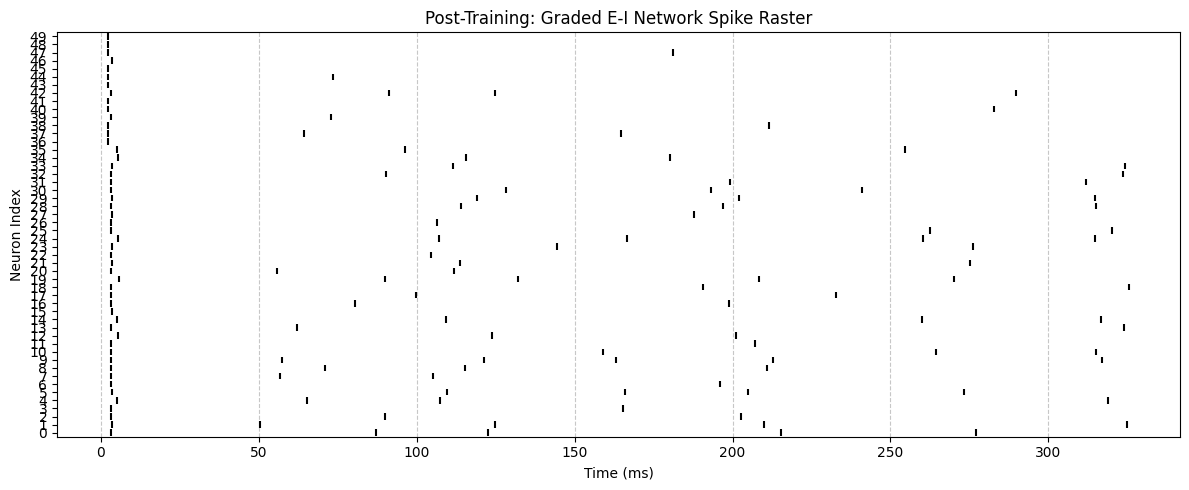

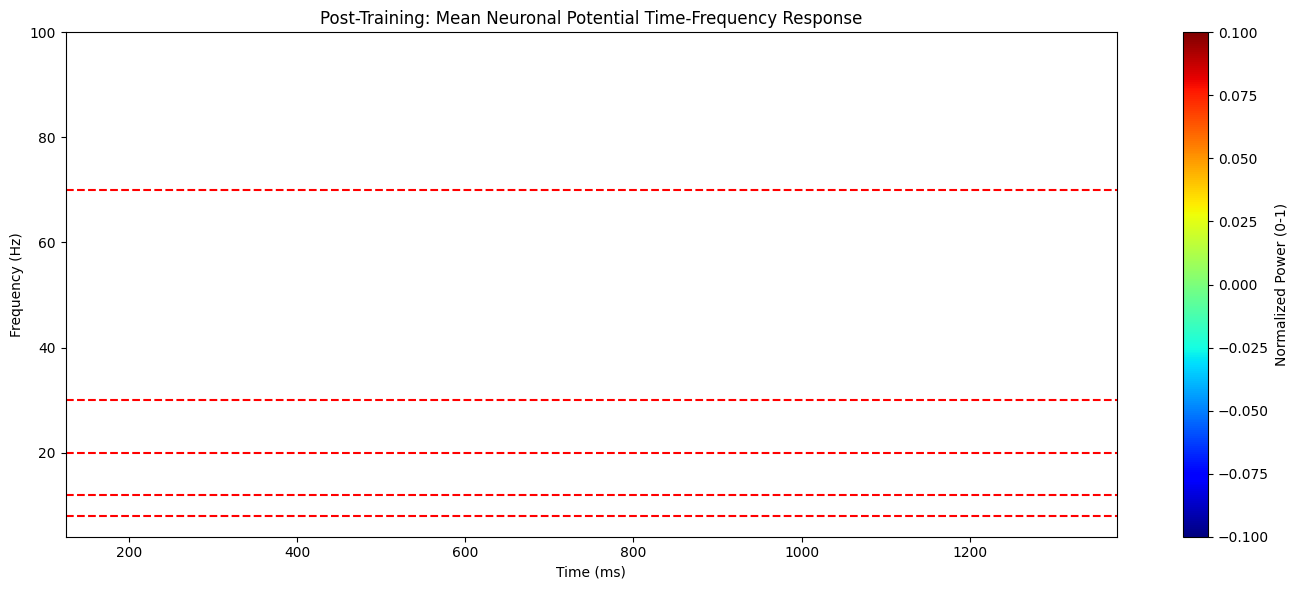

In [ ]:
single_input_amp = inputs[3]
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()
this_params = net.get_parameters()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=this_params, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)

print(f"Post-training simulation completed. Recorded voltages shape: {recorded_voltages_post_training.shape}")

time_axis = jnp.arange(0, t_max_global, dt_global)
plot_voltages_as_image(recorded_voltages_post_training, time_axis, title="Post-Training: Graded E-I Network Voltages")
plot_raster(recorded_voltages_post_training, time_axis, spike_threshold=-20.0, title="Post-Training: Graded E-I Network Spike Raster")
plot_time_frequency_response(recorded_voltages_post_training, time_axis, dt_global,
                             window_size=250.0, overlap=0.95,
                             f_min=1.0, f_max=100.0, title="Post-Training: Mean Neuronal Potential Time-Frequency Response")

## Training

### Optimization loop

In [ ]:
key = jax.random.PRNGKey(42)
initial_params = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=0.1)

# Create GSDR wrapper
optimizer = GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=0.5,
    a_dynamic=True,
    lambda_d=5.0,
    checkpoint_n=5
)

# Initialize State
opt_state = optimizer.init(initial_params)

# Transform the initial parameters for the optimizer
opt_params = transform.inverse(initial_params)

key = jax.random.PRNGKey(0) # This key is for the training loop's random operations
print("Starting training...")

epoch_n = 100

training_log = {
    "loss": [],
    "alpha": [],
    "loss_opt": [],
    "avg_bounded_params": [],
    "std_bounded_params": []
}

for epoch in range(epoch_n):

    key, step_key = jax.random.split(key)
    epoch_loss = 0.0
    epoch_cnt = 0

    for batch_ind, batch in enumerate(dataloader):
        current_batch, label_batch = batch
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        epoch_cnt += 1
        # Get current parameters in the original space for GSDR
        current_network_params = transform.forward(opt_params)

        updates, opt_state = optimizer.update(gradient, opt_state,
            params=current_network_params,   # Required for GSDR
            value=loss_val,      # Required for GSDR
            key=step_key)      # Required for GSDR (using the training loop's step_key)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val

    # Flatten all *physical* parameter arrays into a single array for statistics
    physical_params = transform.forward(opt_params) # Get actual bounded parameters
    all_physical_params_flat = []
    for param_group in physical_params:
        for param_array in param_group.values():
            all_physical_params_flat.append(param_array.flatten())
    all_physical_params_flat = jnp.concatenate(all_physical_params_flat)

    avg_physical_params = jnp.mean(all_physical_params_flat)
    std_physical_params = jnp.std(all_physical_params_flat)

    current_avg_loss = epoch_loss / epoch_cnt
    training_log["loss"].append(current_avg_loss)
    training_log["alpha"].append(opt_state.a)
    training_log["loss_opt"].append(opt_state.loss_opt)
    training_log["avg_bounded_params"].append(avg_physical_params)
    training_log["std_bounded_params"].append(std_physical_params)

    print(f"epoch {epoch}, avg. loss {current_avg_loss:.4f}, alpha {opt_state.a:.4f}, loss_opt {opt_state.loss_opt:.4f}, Avg Bounded Params: {avg_physical_params:.4f}, Std Bounded Params: {std_physical_params:.4f}")

final_params = transform.forward(opt_params)


Starting training...
epoch 0, avg. loss 156.9913, alpha 0.8087, loss_opt 153.5859, Avg Bounded Params: 0.4310, Std Bounded Params: 0.4747
epoch 1, avg. loss 129.5105, alpha 0.5743, loss_opt 126.9978, Avg Bounded Params: 0.3576, Std Bounded Params: 0.4701
epoch 2, avg. loss 138.2025, alpha 0.3121, loss_opt 126.9978, Avg Bounded Params: 0.3179, Std Bounded Params: 0.4606
epoch 3, avg. loss 125.7901, alpha 0.6317, loss_opt 122.4805, Avg Bounded Params: 0.2759, Std Bounded Params: 0.4421
epoch 4, avg. loss 125.9136, alpha 0.7878, loss_opt 118.2215, Avg Bounded Params: 0.2481, Std Bounded Params: 0.4287
epoch 5, avg. loss 126.7447, alpha 0.9952, loss_opt 118.2215, Avg Bounded Params: 0.2193, Std Bounded Params: 0.4100
epoch 6, avg. loss 127.4162, alpha 0.6317, loss_opt 118.2215, Avg Bounded Params: 0.2188, Std Bounded Params: 0.4097
epoch 7, avg. loss 143.4381, alpha 0.5177, loss_opt 118.2215, Avg Bounded Params: 0.2088, Std Bounded Params: 0.4040
epoch 8, avg. loss 143.6774, alpha 0.9983, 

### Visualization

Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 1.00 nA...
Post-training simulation completed. Recorded voltages shape: (50, 15002)


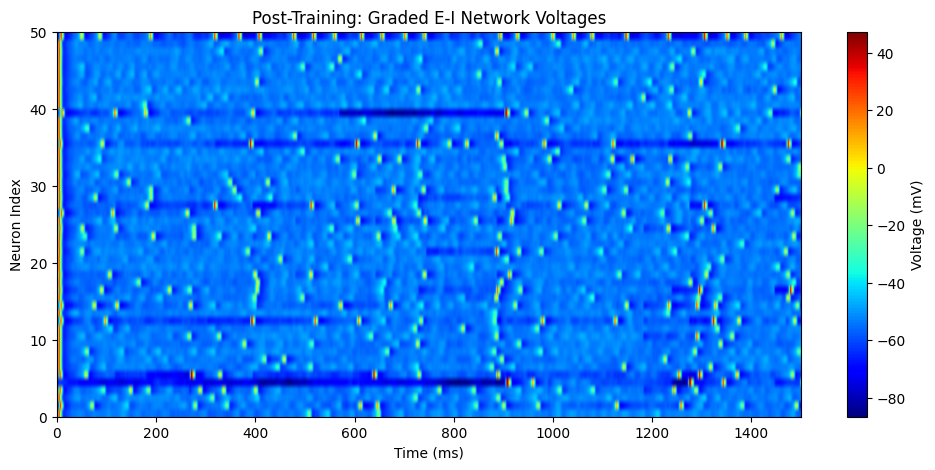

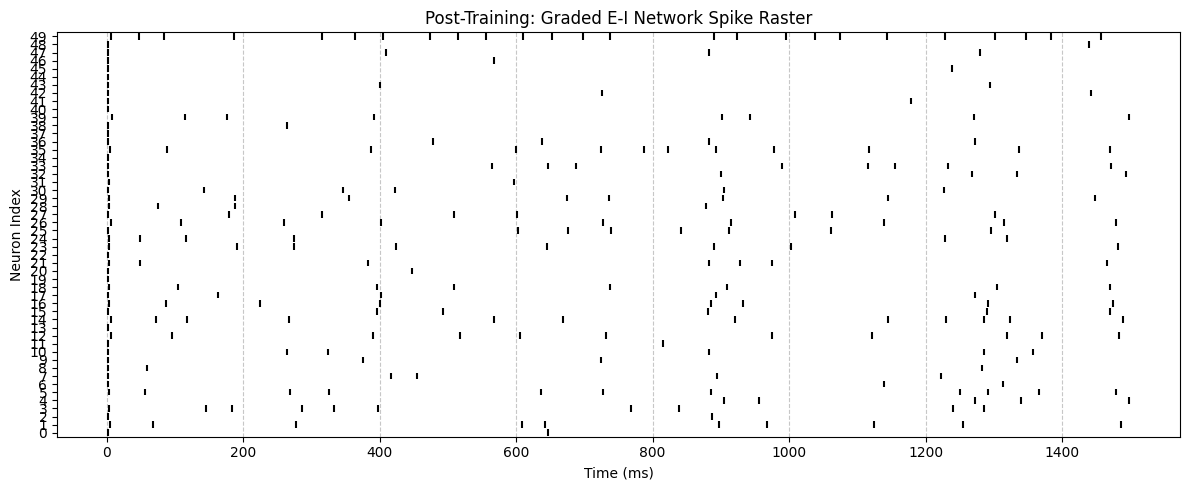

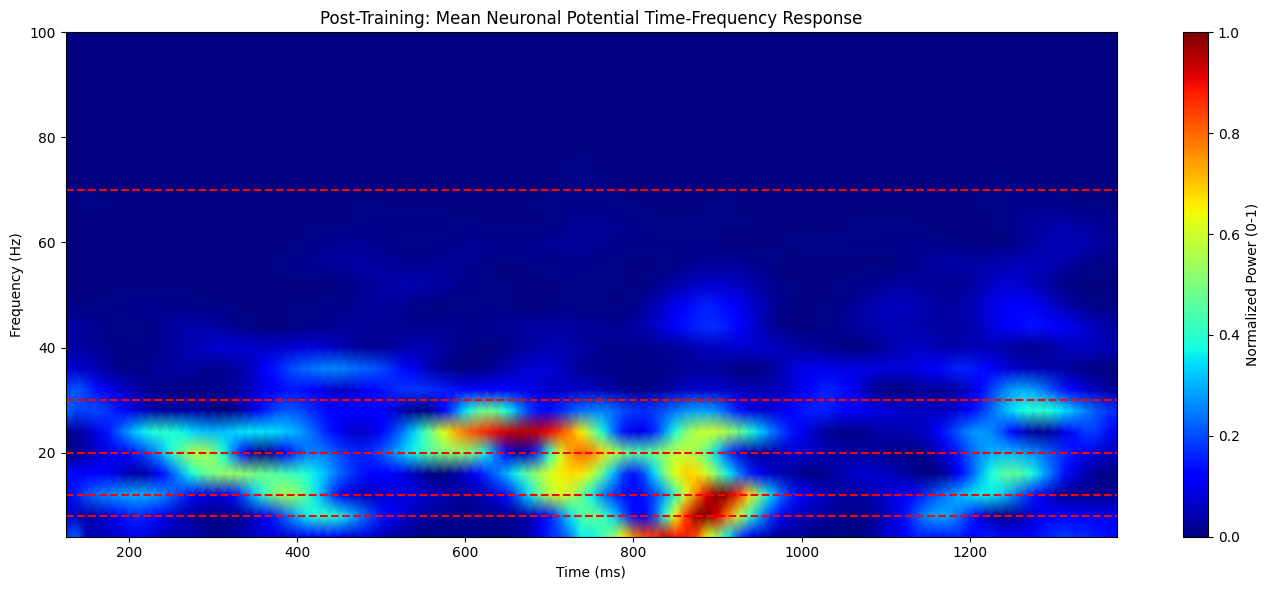

In [ ]:
single_input_amp = inputs[4]
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=final_params, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)

print(f"Post-training simulation completed. Recorded voltages shape: {recorded_voltages_post_training.shape}")

time_axis = jnp.arange(0, t_max_global, dt_global)
plot_voltages_as_image(recorded_voltages_post_training, time_axis, title="Post-Training: Graded E-I Network Voltages")
plot_raster(recorded_voltages_post_training, time_axis, spike_threshold=-20.0, title="Post-Training: Graded E-I Network Spike Raster")
plot_time_frequency_response(recorded_voltages_post_training, time_axis, dt_global,
                             window_size=250.0, overlap=0.95,
                             f_min=1.0, f_max=100.0, title="Post-Training: Mean Neuronal Potential Time-Frequency Response")

Amp: 0.0
Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 0.00 nA...
Amp: 1.0
Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 1.00 nA...


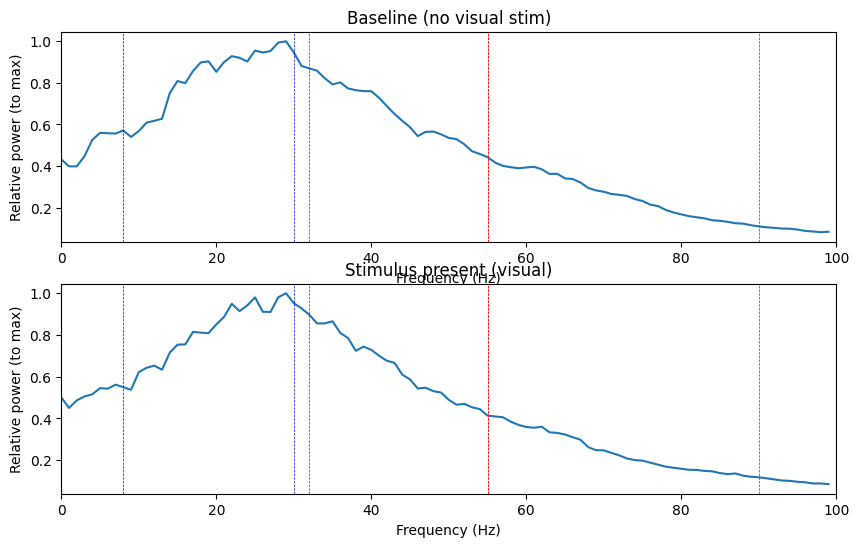

In [ ]:
single_input_amp = inputs[0]
print(f"Amp: {single_input_amp}")
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=final_params, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)
network_avg_psd = get_signal_psd(recorded_voltages_post_training.T, fs=10000)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(network_avg_psd)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Baseline (no visual stim)')
plt.xlim([0, 100])

single_input_amp = inputs[3]
print(f"Amp: {single_input_amp}")
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=final_params_0, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)
network_avg_psd = get_signal_psd(recorded_voltages_post_training.T, fs=10000)

plt.subplot(2, 1, 2)
plt.plot(network_avg_psd)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Stimulus present (visual)')
plt.xlim([0, 100])

plt.show()

### Evaluation

# Spectral tuning

In [11]:
from scipy import ndimage


def get_signal_psd(traces, fs=1000):
  signal = jnp.nanmean(jnp.squeeze(traces), axis=1) # Average voltage across all recorded neurons over time
  # signal = ndimage.uniform_filter1d(signal, size=10)
  N = signal.shape[-1]

  # Compute one-sided FFT and corresponding frequencies for real signals
  signal_fft = jnp.fft.rfft(signal)
  freqs = jnp.fft.rfftfreq(N, 1/fs)
  psd_raw = jnp.abs(signal_fft)**2 / (N * fs)

  target_freqs = jnp.linspace(1.0, 100.0, 100)
  interpolated_psd = jnp.interp(target_freqs, freqs, psd_raw)
  interpolated_psd = ndimage.uniform_filter1d(interpolated_psd, size=jnp.ceil(5*jnp.sqrt(fs/1000)).astype(int))

  max_psd = jnp.max(interpolated_psd)
  scaled_psd = interpolated_psd / (max_psd + 1e-6)
  return scaled_psd


inputs = jnp.array([0.0, 0.0, -10.0, -10.0]) # nA stim amp for the three groups
labels = jnp.zeros((4, 100))

for ik in range(2):
  base_units_spectrum = get_signal_psd(selected_unit_spiking[0, :1000, :])
  labels = labels.at[ik].set(base_units_spectrum)

for ik in range(2, 4):
  stim_units_spectrum = get_signal_psd(selected_unit_spiking[5, 500:1500, :])
  labels = labels.at[ik].set(stim_units_spectrum)

batch_size = 4
dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(batch_size)

dt_global = 0.1
t_max_global = 1500

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
net = net_eig(Ne, Nig, Nil)

gAMPA_lower_bounds = 0.00
gAMPA_upper_bounds = 1.00

gGABA_lower_bounds = 0.00
gGABA_upper_bounds = 1.00

# Correctly define transform as ParamTransform for the entire parameter tree
transform = jx.ParamTransform([
    {"gAMPA": jt.SigmoidTransform(gAMPA_lower_bounds, gAMPA_upper_bounds)},
    {"gGABAa": jt.SigmoidTransform(gGABA_lower_bounds, gGABA_upper_bounds)}
])

net.delete_stimuli()
net.delete_trainables()
net.GradedAMPA.edge("all").make_trainable("gAMPA")
net.GradedGABAa.edge("all").make_trainable("gGABAa")

levels = 2
# Recalculate time_points and checkpoints due to dt change
time_points = t_max_global / dt_global + 1 # 100.0 / 0.005 + 1 = 20000 + 1 = 20001
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

# Ensure recordings are set up for the network if not already done in the model definition
# This ensures that `integrate` captures the necessary neuron activities.
net.delete_recordings()
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()


def simulate(params, input_amp):
    """
    Simulates the network for a given scalar input amplitude.
    The input_amp is a scalar (single stimulus amplitude for a batch item).
    This simulate function is designed for the PSD fitting task.
    """
    # Create currents for a single cell (e.g., cell 0)
    current_amp_nA = input_amp # Assuming input_amp is already in nA, used directly.
    currents = noise_current(
        i_delay=500.0, i_dur=500.0,
        i_amp=current_amp_nA,
        delta_t=dt_global,
        t_max=t_max_global
    )
    # currents = jx.datapoint_to_step_currents(
    #     i_delay=500.0,  # Delay before stimulus starts (ms)
    #     i_dur=500.0,    # Duration of stimulus (ms)
    #     i_amp=[current_amp_nA], # Wrapped in a list to satisfy jx.datapoint_to_step_currents expected input
    #     delta_t=dt,
    #     t_max=t_max
    # )

    # Stimulate cell 0. If multiple cells need stimulation per input,
    # the 'input_amp' would need to be an array of amplitudes or a function of the cell index.
    # FIX: Pass the entire time series 'currents' to data_stimulate, not just currents[0]
    # FIX: Change branch(2) to branch(1) as branch(2) does not exist in current network definition
    net.delete_stimuli()
    data_stimuli = net.cell([ik for ik in range(Ne)]).branch(0).loc(0.0).data_stimulate(currents)

    # Integrate the network dynamics.
    # `traces` will be of shape (num_recorded_nodes, num_timepoints).
    # num_timepoints will be `t_max / dt + 1` if V_init is included.
    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

# Batch the simulate function for multiple input amplitudes
batched_simulate = vmap(simulate, in_axes=(None, 0))


def predict(params, input_amp):
    """
    Predicts a scaled PSD array of shape (100,) for frequencies from 1Hz to 100Hz.
    This function processes a single simulation result (from a scalar input_amp).
    """
    traces = simulate(params, input_amp)  # Shape `(num_recorded_nodes, num_timepoints)`

    # Exclude the initial voltage value (V_init) at traces[:, 0]
    # The `integrate` function typically returns the initial state as the first time point.
    # So the actual time series data starts from index 1.
    signal = jnp.mean(traces[:, 1:], axis=0) # Average voltage across all recorded neurons over time

    N = signal.shape[-1] # Number of time points for PSD calculation (t_max / dt = 20000)
    fs = 1000.0 / dt_global         # Sampling frequency (1Hz / 0.1ms = 10KHz)

    # Compute one-sided FFT and corresponding frequencies for real signals
    signal_fft = jnp.fft.rfft(signal)
    freqs = jnp.fft.rfftfreq(N, d=dt_global/1000)

    # Compute Power Spectral Density
    # P_xx(f) = (1 / (N*fs)) * |X(f)|^2
    # Where X(f) is the FFT of x(t)
    psd_raw = jnp.abs(signal_fft)**2 / (N * fs)

    # Target frequencies for the output (1Hz to 100Hz, 100 points)
    target_freqs = jnp.linspace(1.0, 100.0, 100)

    # Interpolate PSD values at target_freqs
    # jnp.interp handles values outside the `freqs` range by clamping to boundary values.
    # With dt=0.005, freqs will go up to 100Hz, so all target_freqs are within range.
    interpolated_psd = jnp.interp(target_freqs, freqs, psd_raw)

    # Scale the PSD array (normalize by its maximum value)
    # This helps ensure consistency if labels are also normalized, and prevents very large/small loss values.
    # Add a small epsilon to avoid division by zero if all PSD values are zero.
    max_psd = jnp.max(interpolated_psd)
    scaled_psd = interpolated_psd / (max_psd + 1e-6)

    # Ensure shape (100,)
    return scaled_psd


# Batch the predict function for multiple input amplitudes (from the 'inputs' array)
batched_predict = vmap(predict, in_axes=(None, 0))


def loss(opt_params, inputs, labels):
    """
    Loss function for PSD fitting.
    opt_params: optimized network parameters (in transformed space)
    inputs: batch of scalar stimulus amplitudes (shape: (batch_size,))
    labels: batch of target PSD arrays (shape: (batch_size, 100))
    """
    params = transform.forward(opt_params) # Convert optimized params back to original space

    predictions = batched_predict(params, inputs) # Shape (batch_size, 100)

    # sum of square of log of predictions-labels.
    # It should be always positive, and close to 0 if each prediction is equal to the label*
    epsilon = 1e-6 # Small epsilon for numerical stability
    losses_per_sample = jnp.sum(jnp.square(jnp.log((predictions + epsilon) / (labels + epsilon))), axis=1)

    return jnp.nanmean(losses_per_sample) # Average loss across the batch


# JIT the loss function and its gradient for efficiency
jitted_grad = jit(value_and_grad(loss, argnums=0))

Number of newly added trainable parameters: 1800. Total number of trainable parameters: 1800
Number of newly added trainable parameters: 322. Total number of trainable parameters: 2122
Added 50 recordings. See `.recordings` for details.


### Trainer

In [17]:
def net_trainer_temp1(net, optimizer, dataloader, epoch_n=100):

    print("Starting training...")

    initial_params = net.get_parameters()
    opt_state = optimizer.init(initial_params)
    opt_params = transform.inverse(initial_params)
    key = jax.random.PRNGKey(0)

    training_log = {
        "loss": [],
        "alpha": [],
        "loss_opt": [],
        "avg_bounded_params": [],
        "std_bounded_params": []
    }

    mid_params = []

    for epoch in range(epoch_n):

        key, step_key = jax.random.split(key)
        epoch_loss = 0.0
        epoch_cnt = 0

        for batch_ind, batch in enumerate(dataloader):
            current_batch, label_batch = batch
            loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
            epoch_cnt += 1
            # Get current parameters in the original space for GSDR
            current_network_params = transform.forward(opt_params)

            updates, opt_state = optimizer.update(gradient, opt_state,
                params=current_network_params,   # Required for GSDR
                value=loss_val,      # Required for GSDR
                key=step_key)      # Required for GSDR (using the training loop's step_key)
            opt_params = optax.apply_updates(opt_params, updates)
            epoch_loss += loss_val

        # Flatten all *physical* parameter arrays into a single array for statistics
        physical_params = transform.forward(opt_params) # Get actual bounded parameters
        all_physical_params_flat = []
        for param_group in physical_params:
            for param_array in param_group.values():
                all_physical_params_flat.append(param_array.flatten())
        all_physical_params_flat = jnp.concatenate(all_physical_params_flat)

        avg_physical_params = jnp.mean(all_physical_params_flat)
        std_physical_params = jnp.std(all_physical_params_flat)

        current_avg_loss = epoch_loss / epoch_cnt
        training_log["loss"].append(current_avg_loss)
        training_log["alpha"].append(opt_state.a)
        training_log["loss_opt"].append(opt_state.loss_opt)
        training_log["avg_bounded_params"].append(avg_physical_params)
        training_log["std_bounded_params"].append(std_physical_params)

        if epoch % 100 == 0 and epoch > 10:
            mid_params.append(transform.forward(opt_params))

        print(f"epoch {epoch}, avg. loss {current_avg_loss:.4f}, alpha {opt_state.a:.4f}, loss_opt {opt_state.loss_opt:.4f}, Avg Bounded Params: {avg_physical_params:.4f}, Std Bounded Params: {std_physical_params:.4f}")

    final_params = transform.forward(opt_params)

    return final_params, training_log, mid_params


Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: -10.00 nA...
Post-training simulation completed. Recorded voltages shape: (50, 15002)


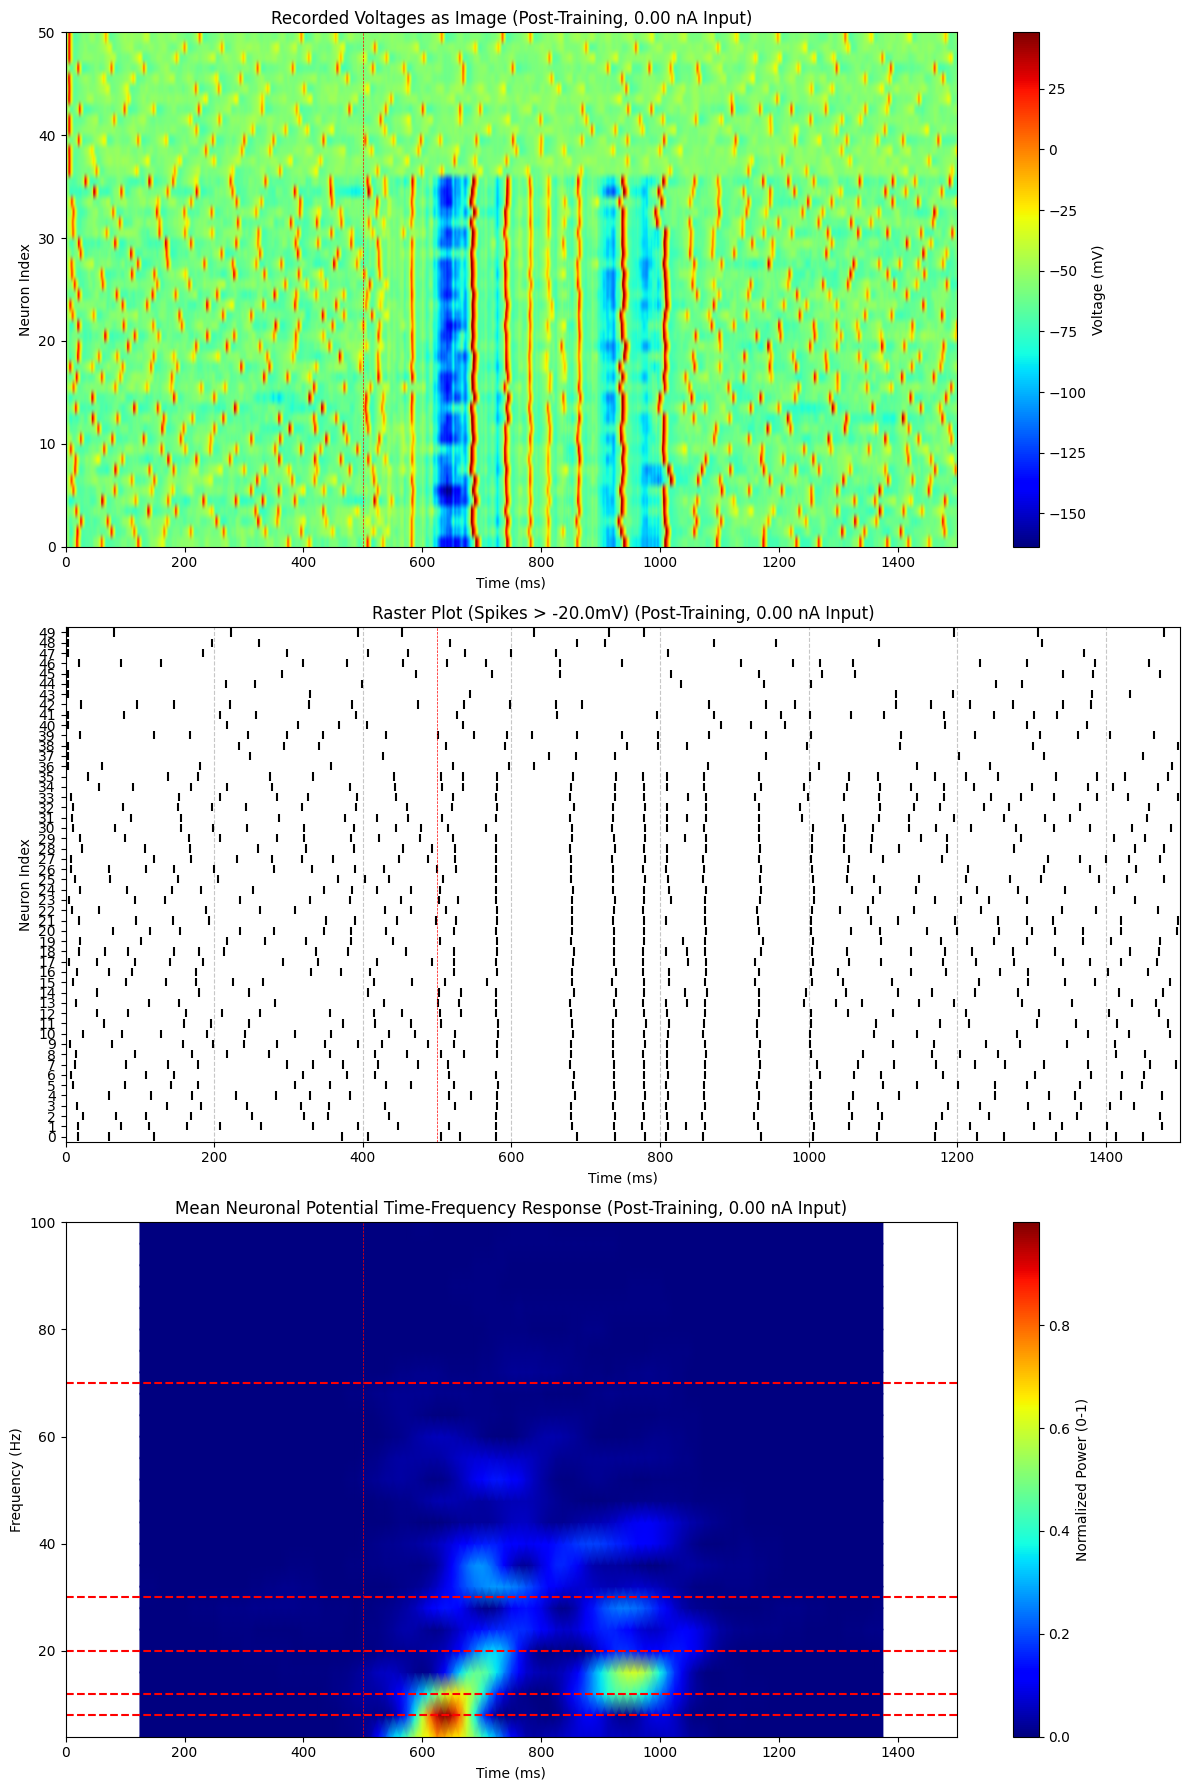

In [20]:
net.set("amp_noise", 0.015)
net.cell([i for i in range(Ne)]).set("amp_noise", 0.025)

single_input_amp = inputs[3]*1.0
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

this_params = net.get_parameters()
# this_params = initial_params_0
# this_params = final_params_0

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=this_params, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)

print(f"Post-training simulation completed. Recorded voltages shape: {recorded_voltages_post_training.shape}")

time_axis = jnp.arange(0, t_max_global, dt_global)

# Call the new combined visualization function
plot_full_simulation_summary(recorded_voltages_post_training, time_axis, dt_global,
                             spike_threshold=-20.0,
                             window_size=250.0, overlap=0.95,
                             f_min=1.0, f_max=100.0,
                             title_suffix="(Post-Training, 0.00 nA Input)")



In [ ]:
single_input_amp = inputs[0]
print(f"Amp: {single_input_amp}")
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=final_params_0, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)
network_avg_psd = get_signal_psd(recorded_voltages_post_training.T, fs=10000)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(network_avg_psd)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Baseline (no visual stim)')
plt.xlim([0, 100])

single_input_amp = inputs[3]*10.0
print(f"Amp: {single_input_amp}")
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=final_params_0, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)
network_avg_psd = get_signal_psd(recorded_voltages_post_training.T[5000:10000, :], fs=10000)

plt.subplot(2, 1, 2)
plt.plot(network_avg_psd)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Stimulus present (visual)')
plt.xlim([10, 100])
plt.ylim([0, 0.1])

plt.show()

Amp: 0.0
Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 0.00 nA...


NameError: name 'final_params_0' is not defined

In [ ]:
recorded_voltages_post_training.T.shape

(15002, 50)

### TODO:

0. Core Behavior : Gamma (narrow/) weak ping

0.A. Noise process and gLeak

0.B. Firing rate changes (Spk/Sec) [5-10] -> [10-20]

1. Data PSD + tfPSD

2. Model PSD + tfPSD

3. Initial + mid + Final

4. Correlation (model to data, PSD)

5. Loss(correlation)

Amp: 0.0
Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 0.00 nA...
Amp: 2.0
Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 2.00 nA...


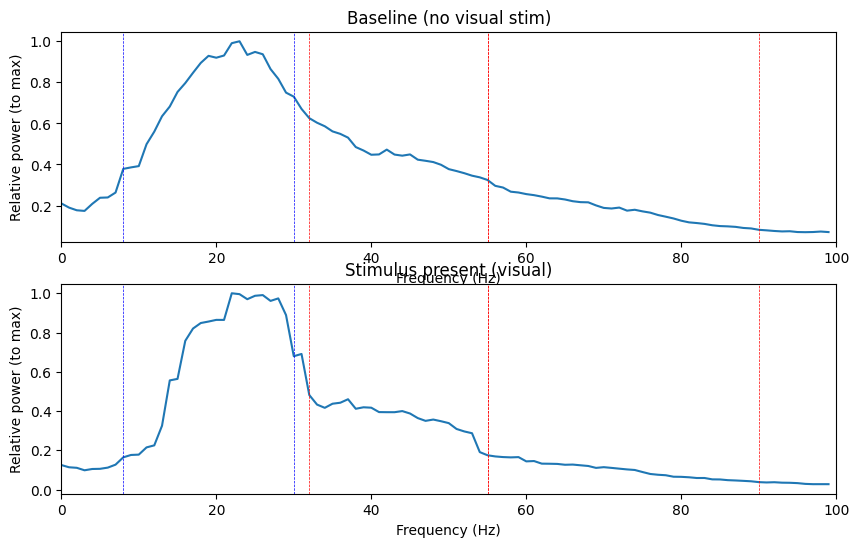

In [ ]:
# Ne = 36 # Number of Excitatory neurons
# Nig = 7 # Number of Global inhibitory interneurons (SST-like)
# Nil = 7 # Number of Local inhibitory interneurons (PV-like))
# net2 = net_eig(Ne, Nig, Nil)
# initial_params_0 = net2.get_parameters()

single_input_amp = inputs[0]
print(f"Amp: {single_input_amp}")
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=initial_params_0, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)
network_avg_psd = get_signal_psd(recorded_voltages_post_training.T, fs=10000)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(network_avg_psd)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Baseline (no visual stim)')
plt.xlim([0, 100])

single_input_amp = inputs[3]*2
print(f"Amp: {single_input_amp}")
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=initial_params_0, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)
network_avg_psd = get_signal_psd(recorded_voltages_post_training.T, fs=10000)

plt.subplot(2, 1, 2)
plt.plot(network_avg_psd)
plt.axvline(x=8, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=0.5)
plt.axvline(x=32, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=55, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=90, color='red', linestyle='--', linewidth=0.5)
plt.ylabel('Relative power (to max)')
plt.xlabel('Frequency (Hz)')
plt.title('Stimulus present (visual)')
plt.xlim([0, 100])

plt.show()

In [ ]:
key = jax.random.PRNGKey(42)
initial_params_0 = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=0.5)

# Create GSDR wrapper
optimizer = GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=0.5,
    a_dynamic=True,
    lambda_d=5.0,
    checkpoint_n=4
)

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
# net = net_eig(Ne, Nig, Nil)

final_params_0, log_net_0, mid_params_0 = net_trainer_temp1(net, optimizer, dataloader, 50)

Starting training...
epoch 0, avg. loss 525.5114, alpha 0.5000, loss_opt 525.5114, Avg Bounded Params: nan, Std Bounded Params: nan
epoch 1, avg. loss nan, alpha 0.5000, loss_opt 525.5114, Avg Bounded Params: nan, Std Bounded Params: nan
epoch 2, avg. loss nan, alpha 0.5000, loss_opt 525.5114, Avg Bounded Params: nan, Std Bounded Params: nan
epoch 3, avg. loss nan, alpha 0.5000, loss_opt 525.5114, Avg Bounded Params: nan, Std Bounded Params: nan
epoch 4, avg. loss nan, alpha 0.5000, loss_opt 525.5114, Avg Bounded Params: nan, Std Bounded Params: nan
epoch 5, avg. loss nan, alpha 0.5000, loss_opt 525.5114, Avg Bounded Params: nan, Std Bounded Params: nan


KeyboardInterrupt: 

In [ ]:
mid_params_0

[[[{'gAMPA': Array([0.17405843, 0.02963705, 0.01004832, ..., 0.09406678, 0.15850195,
           0.11333694], dtype=float64)},
   {'gGABAa': Array([0.02696043, 0.16878015, 0.28123716, 0.15768532, 0.02747234,
           0.1521197 , 0.31126596, 0.1528573 , 0.02892982, 0.02734005,
           0.02767427, 0.02807799, 0.17698437, 0.2940201 , 0.02695613,
           0.30979421, 0.02626056, 0.18647844, 0.02666466, 0.2943124 ,
           0.38119223, 0.02231078, 0.35776971, 0.02583893, 0.26806427,
           0.02849815, 0.02506735, 0.02683248, 0.02726791, 0.18267903,
           0.29768443, 0.02982123, 0.02408184, 0.03114188, 0.31420374,
           0.0258679 , 0.03047835, 0.16877511, 0.30833797, 0.19471837,
           0.02797887, 0.1698491 , 0.30755971, 0.16480716, 0.02851255,
           0.02562718, 0.26532614, 0.03006428, 0.28915363, 0.30832763,
           0.02788202, 0.36831503, 0.02722702, 0.18217032, 0.02557582,
           0.2668599 , 0.32994827, 0.02294845, 0.3760448 , 0.02557861,
           0

In [ ]:
key = jax.random.PRNGKey(42)
initial_params_1 = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=0.4)

# Create GSDR wrapper
optimizer = GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=0.0,
    a_dynamic=False,
    lambda_d=5.0,
    checkpoint_n=6
)

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
# net = net_eig(Ne, Nig, Nil)

final_params_1, log_net_1, mid_params_1 = net_trainer_temp1(net, optimizer, dataloader, 20)

Starting training...
epoch 0, avg. loss 177.3725, alpha 0.0000, loss_opt 177.3725, Avg Bounded Params: 0.0894, Std Bounded Params: 0.0639
epoch 1, avg. loss 330.1970, alpha 0.0000, loss_opt 177.3725, Avg Bounded Params: 0.1417, Std Bounded Params: 0.1187
epoch 2, avg. loss 130.5638, alpha 0.0000, loss_opt 130.5638, Avg Bounded Params: 0.1995, Std Bounded Params: 0.1721
epoch 3, avg. loss 144.3869, alpha 0.0000, loss_opt 130.5638, Avg Bounded Params: 0.2554, Std Bounded Params: 0.2213
epoch 4, avg. loss 132.7826, alpha 0.0000, loss_opt 130.5638, Avg Bounded Params: 0.3053, Std Bounded Params: 0.2644
epoch 5, avg. loss 134.0724, alpha 0.0000, loss_opt 130.5638, Avg Bounded Params: 0.3477, Std Bounded Params: 0.3008
epoch 6, avg. loss 148.1787, alpha 0.0000, loss_opt 130.5638, Avg Bounded Params: 0.3829, Std Bounded Params: 0.3308
epoch 7, avg. loss 136.3012, alpha 0.0000, loss_opt 130.5638, Avg Bounded Params: 0.4115, Std Bounded Params: 0.3552
epoch 8, avg. loss 144.3779, alpha 0.0000, 

In [ ]:
key = jax.random.PRNGKey(42)
initial_params_2 = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=1.0)

# Create GSDR wrapper
optimizer = GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=0.25,
    a_dynamic=False,
    lambda_d=5.0,
    checkpoint_n=6
)

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
# net = net_eig(Ne, Nig, Nil)

final_params_2, log_net_2, mid_params_2 = net_trainer_temp1(net, optimizer, dataloader, 500)

Starting training...
epoch 0, avg. loss 177.3725, alpha 0.2500, loss_opt 177.3725, Avg Bounded Params: 0.0776, Std Bounded Params: 0.0518
epoch 1, avg. loss 221.6636, alpha 0.2500, loss_opt 177.3725, Avg Bounded Params: 0.1107, Std Bounded Params: 0.1062
epoch 2, avg. loss 219.7083, alpha 0.2500, loss_opt 177.3725, Avg Bounded Params: 0.1485, Std Bounded Params: 0.1687
epoch 3, avg. loss 132.0894, alpha 0.2500, loss_opt 132.0894, Avg Bounded Params: 0.1826, Std Bounded Params: 0.2209
epoch 4, avg. loss 185.1116, alpha 0.2500, loss_opt 132.0894, Avg Bounded Params: 0.2078, Std Bounded Params: 0.2673
epoch 5, avg. loss 154.2307, alpha 0.2500, loss_opt 132.0894, Avg Bounded Params: 0.2211, Std Bounded Params: 0.2909
epoch 6, avg. loss 157.2667, alpha 0.2500, loss_opt 132.0894, Avg Bounded Params: 0.2336, Std Bounded Params: 0.3106
epoch 7, avg. loss 140.7438, alpha 0.2500, loss_opt 132.0894, Avg Bounded Params: 0.2359, Std Bounded Params: 0.3156
epoch 8, avg. loss 126.1095, alpha 0.2500, 

In [ ]:
key = jax.random.PRNGKey(42)
initial_params_3 = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=1.0)

# Create GSDR wrapper
optimizer = GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=0.5,
    a_dynamic=False,
    lambda_d=5.0,
    checkpoint_n=5
)

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
# net = net_eig(Ne, Nig, Nil)

final_params_3, log_net_3, mid_params_3 = net_trainer_temp1(net, optimizer, dataloader, 500)

Starting training...
epoch 0, avg. loss 132.9440, alpha 0.5000, loss_opt 112.3021, Avg Bounded Params: 0.0753, Std Bounded Params: 0.0467
epoch 1, avg. loss 108.9845, alpha 0.5000, loss_opt 103.1532, Avg Bounded Params: 0.0890, Std Bounded Params: 0.0761
epoch 2, avg. loss 110.4228, alpha 0.5000, loss_opt 103.1532, Avg Bounded Params: 0.1004, Std Bounded Params: 0.1077
epoch 3, avg. loss 107.7734, alpha 0.5000, loss_opt 102.7840, Avg Bounded Params: 0.1147, Std Bounded Params: 0.1408
epoch 4, avg. loss 101.5153, alpha 0.5000, loss_opt 100.0460, Avg Bounded Params: 0.1298, Std Bounded Params: 0.1724
epoch 5, avg. loss 99.1382, alpha 0.5000, loss_opt 96.9213, Avg Bounded Params: 0.1432, Std Bounded Params: 0.1960
epoch 6, avg. loss 109.3788, alpha 0.5000, loss_opt 96.9213, Avg Bounded Params: 0.1562, Std Bounded Params: 0.2171
epoch 7, avg. loss 103.5923, alpha 0.5000, loss_opt 96.2207, Avg Bounded Params: 0.1676, Std Bounded Params: 0.2337
epoch 8, avg. loss 115.5610, alpha 0.5000, loss

In [ ]:
key = jax.random.PRNGKey(42)
initial_params_4 = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=1.0)

# Create GSDR wrapper
optimizer = GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=0.75,
    a_dynamic=False,
    lambda_d=5.0,
    checkpoint_n=5
)

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
# net = net_eig(Ne, Nig, Nil)

final_params_4, log_net_4, mid_params_4 = net_trainer_temp1(net, optimizer, dataloader, 500)

Starting training...
epoch 0, avg. loss 133.0053, alpha 0.7500, loss_opt 112.4246, Avg Bounded Params: 0.0632, Std Bounded Params: 0.0264
epoch 1, avg. loss 111.8678, alpha 0.7500, loss_opt 108.0850, Avg Bounded Params: 0.0700, Std Bounded Params: 0.0397
epoch 2, avg. loss 107.1465, alpha 0.7500, loss_opt 97.8001, Avg Bounded Params: 0.0745, Std Bounded Params: 0.0494
epoch 3, avg. loss 106.3681, alpha 0.7500, loss_opt 97.8001, Avg Bounded Params: 0.0795, Std Bounded Params: 0.0640
epoch 4, avg. loss 109.7613, alpha 0.7500, loss_opt 97.8001, Avg Bounded Params: 0.0795, Std Bounded Params: 0.0635
epoch 5, avg. loss 113.4279, alpha 0.7500, loss_opt 97.8001, Avg Bounded Params: 0.0898, Std Bounded Params: 0.0853
epoch 6, avg. loss 111.7319, alpha 0.7500, loss_opt 97.8001, Avg Bounded Params: 0.0998, Std Bounded Params: 0.1061
epoch 7, avg. loss 104.4436, alpha 0.7500, loss_opt 97.8001, Avg Bounded Params: 0.0989, Std Bounded Params: 0.0998
epoch 8, avg. loss 109.9568, alpha 0.7500, loss_o

In [ ]:
key = jax.random.PRNGKey(42)
initial_params_5 = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=1.0)

# Create GSDR wrapper
optimizer = GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=1.0,
    a_dynamic=False,
    lambda_d=5.0,
    checkpoint_n=5
)

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
# net = net_eig(Ne, Nig, Nil)

final_params_5, log_net_5, mid_params_5 = net_trainer_temp1(net, optimizer, dataloader, 500)

Starting training...
epoch 0, avg. loss 158.4557, alpha 1.0000, loss_opt 153.5859, Avg Bounded Params: 0.0582, Std Bounded Params: 0.0209
epoch 1, avg. loss 164.9212, alpha 1.0000, loss_opt 153.5859, Avg Bounded Params: 0.0590, Std Bounded Params: 0.0241
epoch 2, avg. loss 168.9114, alpha 1.0000, loss_opt 153.5859, Avg Bounded Params: 0.0589, Std Bounded Params: 0.0236
epoch 3, avg. loss 168.4471, alpha 1.0000, loss_opt 153.5859, Avg Bounded Params: 0.0597, Std Bounded Params: 0.0265
epoch 4, avg. loss 172.8355, alpha 1.0000, loss_opt 153.5859, Avg Bounded Params: 0.0607, Std Bounded Params: 0.0321
epoch 5, avg. loss 164.0992, alpha 1.0000, loss_opt 153.5859, Avg Bounded Params: 0.0603, Std Bounded Params: 0.0304
epoch 6, avg. loss 164.3684, alpha 1.0000, loss_opt 153.5859, Avg Bounded Params: 0.0616, Std Bounded Params: 0.0378
epoch 7, avg. loss 165.1795, alpha 1.0000, loss_opt 149.9238, Avg Bounded Params: 0.0619, Std Bounded Params: 0.0394
epoch 8, avg. loss 177.0110, alpha 1.0000, 

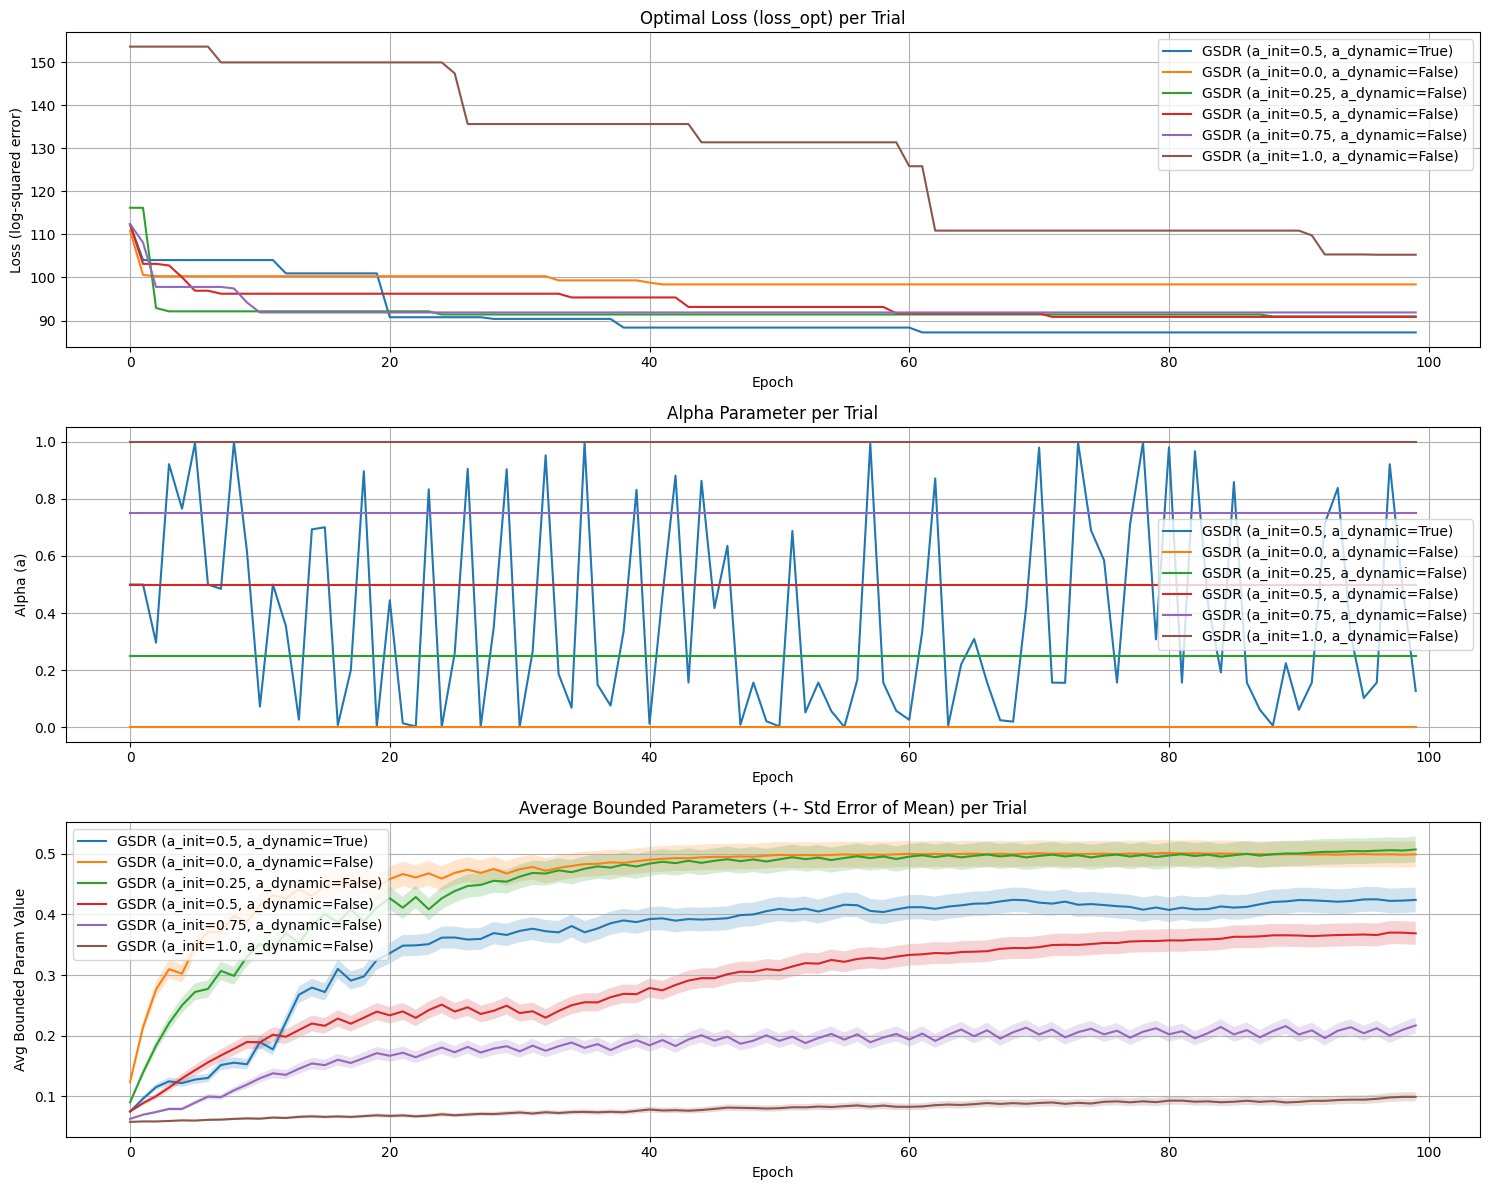

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of log_net variables
log_nets = [
    log_net_0,
    log_net_1,
    log_net_2,
    log_net_3,
    log_net_4,
    log_net_5
]

# Labels for each run (can be customized based on initial alpha or dynamic setting)
run_labels = [
    'GSDR (a_init=0.5, a_dynamic=True)',
    'GSDR (a_init=0.0, a_dynamic=False)',
    'GSDR (a_init=0.25, a_dynamic=False)',
    'GSDR (a_init=0.5, a_dynamic=False)',
    'GSDR (a_init=0.75, a_dynamic=False)',
    'GSDR (a_init=1.0, a_dynamic=False)'
]

epochs = np.arange(len(log_nets[0]['loss'])) # Assuming all logs have the same number of epochs

# Calculate the total number of trainable parameters once
# This assumes 'initial_params' is available globally from the previous training setup
initial_params = net.get_parameters() # Re-get initial params to count them
num_trainable_params = 0
for param_group in initial_params:
    for param_array in param_group.values():
        num_trainable_params += param_array.size

# Handle case to avoid division by zero if no trainable parameters
if num_trainable_params == 0:
    print("Warning: No trainable parameters found. Error bars will not be scaled.")
    sqrt_num_trainable_params = 1.0
else:
    sqrt_num_trainable_params = np.sqrt(num_trainable_params)

plt.figure(figsize=(15, 12))

# Subplot 1: loss_opt per trial
plt.subplot(3, 1, 1)
for i, log_net in enumerate(log_nets):
    plt.plot(epochs, log_net['loss_opt'], label=run_labels[i])
plt.title('Optimal Loss (loss_opt) per Trial')
plt.xlabel('Epoch')
plt.ylabel('Loss (log-squared error)')
plt.legend()
plt.grid(True)

# Subplot 2: alpha per trial
plt.subplot(3, 1, 2)
for i, log_net in enumerate(log_nets):
    plt.plot(epochs, log_net['alpha'], label=run_labels[i])
plt.title('Alpha Parameter per Trial')
plt.xlabel('Epoch')
plt.ylabel('Alpha (a)')
plt.legend()
plt.grid(True)

# Subplot 3: Bounded Params Avg with error bars (+- Std)
plt.subplot(3, 1, 3)
for i, log_net in enumerate(log_nets):
    avg_params = np.array(log_net['avg_bounded_params'])
    std_params = np.array(log_net['std_bounded_params'])

    # Scale std_params by sqrt(num_trainable_params)
    scaled_std_params = 2*std_params / sqrt_num_trainable_params

    plt.plot(epochs, avg_params, label=run_labels[i]) # Plot the mean line
    plt.fill_between(epochs, avg_params - scaled_std_params, avg_params + scaled_std_params, alpha=0.2) # Fill the area for std dev
plt.title('Average Bounded Parameters (+- Std Error of Mean) per Trial')
plt.xlabel('Epoch')
plt.ylabel('Avg Bounded Param Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_logs_summary.svg', format='svg')

Added 50 recordings. See `.recordings` for details.
Running post-training simulation with input amplitude: 2.00 nA...
Post-training simulation completed. Recorded voltages shape: (50, 15002)


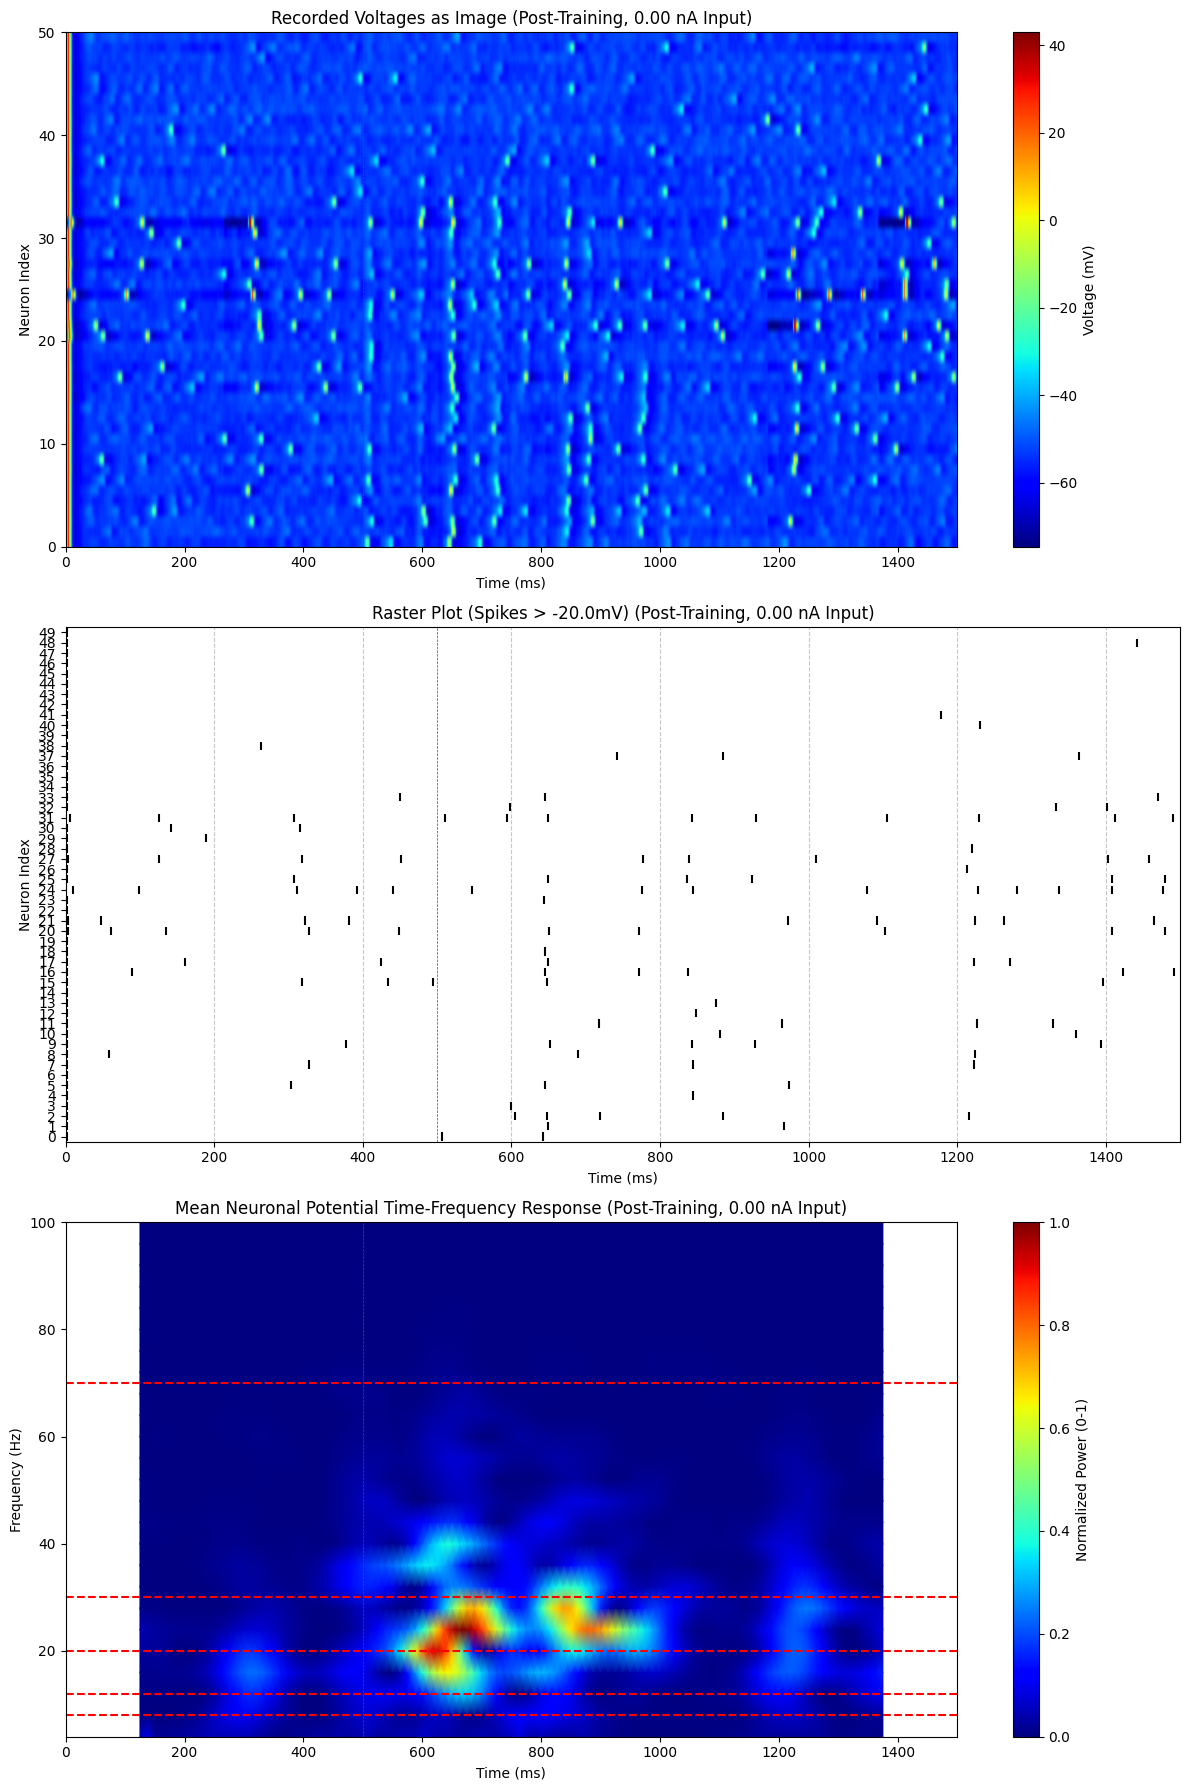

In [ ]:
single_input_amp = inputs[3]*2
sim_noise_current_pulse = noise_current(
    i_delay=500.0,
    i_dur=500.0,
    i_amp=single_input_amp,
    delta_t=dt_global,
    t_max=t_max_global
)

net.delete_stimuli()
net.delete_recordings()
data_stimuli_single_run = net.cell([ik for ik in range(Ne)]).branch(0).loc(1.0).data_stimulate(sim_noise_current_pulse)
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()

print(f"Running post-training simulation with input amplitude: {single_input_amp:.2f} nA...")
recorded_voltages_post_training = jx.integrate(net, params=final_params_0, data_stimuli=data_stimuli_single_run, checkpoint_lengths=checkpoints)

print(f"Post-training simulation completed. Recorded voltages shape: {recorded_voltages_post_training.shape}")

time_axis = jnp.arange(0, t_max_global, dt_global)

# Call the new combined visualization function
plot_full_simulation_summary(recorded_voltages_post_training, time_axis, dt_global,
                             spike_threshold=-20.0,
                             window_size=250.0, overlap=0.95,
                             f_min=1.0, f_max=100.0,
                             title_suffix="(Post-Training, 0.00 nA Input)")

# EoN

In [ ]:
def net_eig(num_e: int, num_ig: int, num_il: int):
    """
    Constructs a JAXley neural network with specified numbers of excitatory and inhibitory neurons.

    Args:
        num_e (int): Number of Excitatory neurons.
        num_ig (int): Number of Global inhibitory interneurons (SST-like).
        num_il (int): Number of Local inhibitory interneurons (PV-like).

    Returns:
        jx.Network: The constructed JAXley network object.
    """
    comp = jx.Compartment()
    branch = jx.Branch(comp, ncomp=1)

    e_cells = [jx.Cell(branch, parents=[-1, 0]) for _ in range(num_e)]
    i_cells_g = [jx.Cell(branch, parents=[-1, 0]) for _ in range(num_ig)]
    i_cells_l = [jx.Cell(branch, parents=[-1, 0]) for _ in range(num_il)]

    # Note: cnte logic removed as it's not strictly necessary inside the loop
    # and initial_amp_noise can be set directly based on cell type if needed.
    # For now, uniform noise amp for all cells as per previous state.
    for cell in e_cells + i_cells_g + i_cells_l:
        cell.insert(HH())
        cell.insert(Inoise(initial_amp_noise=0.01, initial_tau=10.0))
        cell.radius = 10.0  #  geometry for excitability
        cell.length = 10.0

    # 2. Define the Network
    net = jx.Network(e_cells + i_cells_g + i_cells_l)

    # 3. Connectivity (All-to-All between populations)

    # E -> E (AMPA)
    pre = net.cell([ik for ik in range(num_e)]).branch(0).loc(0.0)
    post = net.cell([ik for ik in range(num_e)]).branch(0).loc(1.0)
    fully_connect(pre, post, GradedAMPA(tauD_AMPA=25.0))

    # E -> I (AMPA)
    pre = net.cell([ik for ik in range(num_e)]).branch(0).loc(0.0)
    post = net.cell([ik for ik in range(num_e, num_e+num_ig+num_il)]).branch(0).loc(1.0)
    fully_connect(pre, post, GradedAMPA(tauD_AMPA=25.0))

    # Ig -> E (GABAa)
    pre = net.cell([ik for ik in range(num_e, num_e+num_ig)]).branch(0).loc(0.0)
    post = net.cell([ik for ik in range(num_e)]).branch(0).loc(1.0)
    fully_connect(pre, post, GradedGABAa(tauD_GABAa=25.0))

    # Il -> subset of (E + Ig + Il) (GABAa)
    pre_il = net.cell([ik for ik in range(num_e+num_ig, num_e+num_ig+num_il)]).branch(0).loc(0.0)

    # Define the pool of possible postsynaptic neurons (indices 0 to 50)
    num_posts_to_select = 10
    posts_pool_indices = jnp.arange(0, num_e + num_ig + num_il - 1) # Adjust range to avoid exceeding total cells
    key_conn = jax.random.PRNGKey(5678)
    selected_post_indices = np.array(jax.random.choice(key_conn, posts_pool_indices, shape=(num_posts_to_select,), replace=False))
    post_il = net.cell(selected_post_indices).branch(0).loc(1.0)

    # Connect all presynaptic Il cells to this selected subset of postsynaptic cells
    fully_connect(pre_il, post_il, GradedGABAa(tauD_GABAa=25.0))

    net.insert(Leak())

    # net.compute_xyz()
    # net.rotate(180)
    # net.arrange_in_layers(layers=[num_e, num_ig + num_il], within_layer_offset=100.0, between_layer_offset=200.0)
    # fig, ax = plt.subplots(1, 1, figsize=(6, 12))
    # _ = net.vis(ax=ax, detail="full")

    return net

In [ ]:
dt_global = 0.025
t_max_global = 1500

Ne = 36 # Number of Excitatory neurons
Nig = 7 # Number of Global inhibitory interneurons (SST-like)
Nil = 7 # Number of Local inhibitory interneurons (PV-like))
net = net_eig(Ne, Nig, Nil)

gAMPA_lower_bounds = 0.00
gAMPA_upper_bounds = 1.00

gGABA_lower_bounds = 0.00
gGABA_upper_bounds = 1.00

# Correctly define transform as ParamTransform for the entire parameter tree
transform = jx.ParamTransform([
    {"gAMPA": jt.SigmoidTransform(gAMPA_lower_bounds, gAMPA_upper_bounds)},
    {"gGABAa": jt.SigmoidTransform(gGABA_lower_bounds, gGABA_upper_bounds)}
])

net.delete_stimuli()
net.delete_trainables()
net.GradedAMPA.edge("all").make_trainable("gAMPA")
net.GradedGABAa.edge("all").make_trainable("gGABAa")

levels = 2
# Recalculate time_points and checkpoints due to dt change
time_points = t_max_global / dt_global + 1 # 100.0 / 0.005 + 1 = 20000 + 1 = 20001
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

# Ensure recordings are set up for the network if not already done in the model definition
# This ensures that `integrate` captures the necessary neuron activities.
net.delete_recordings()
net.cell([i for i in range(Ne+Nig+Nil)]).branch(0).loc(0.0).record()


def simulate(params, input_amp):
    """
    Simulates the network for a given scalar input amplitude.
    The input_amp is a scalar (single stimulus amplitude for a batch item).
    This simulate function is designed for the PSD fitting task.
    """
    # Create currents for a single cell (e.g., cell 0)
    current_amp_nA = input_amp # Assuming input_amp is already in nA, used directly.
    currents = noise_current(
        i_delay=500.0, i_dur=500.0,
        i_amp=current_amp_nA,
        delta_t=dt_global,
        t_max=t_max_global
    )
    jax.debug.print("simulate: currents has nan: {}", jnp.any(jnp.isnan(currents)))

    data_stimuli = net.cell([ik for ik in range(Ne)]).branch(0).loc(0.0).data_stimulate(currents)

    # Integrate the network dynamics.
    # `traces` will be of shape (num_recorded_nodes, num_timepoints).
    # num_timepoints will be `t_max / dt + 1` if V_init is included.
    traces = jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)
    jax.debug.print("simulate: traces has nan: {}", jnp.any(jnp.isnan(traces)))
    return traces

# Batch the simulate function for multiple input amplitudes
batched_simulate = vmap(simulate, in_axes=(None, 0))


def predict(params, input_amp):
    """
    Predicts a scaled PSD array of shape (100,) for frequencies from 1Hz to 100Hz.
    This function processes a single simulation result (from a scalar input_amp).
    """
    traces = simulate(params, input_amp)  # Shape `(num_recorded_nodes, num_timepoints)`

    # Exclude the initial voltage value (V_init) at traces[:, 0]
    # The `integrate` function typically returns the initial state as the first time point.
    # So the actual time series data starts from index 1.
    signal = jnp.mean(traces[:, 1:], axis=0) # Average voltage across all recorded neurons over time
    jax.debug.print("predict: signal has nan: {}", jnp.any(jnp.isnan(signal)))

    N = signal.shape[-1] # Number of time points for PSD calculation (t_max / dt = 20000)
    fs = 1000.0 / dt_global         # Sampling frequency (1Hz / 0.1ms = 10KHz)

    # Compute one-sided FFT and corresponding frequencies for real signals
    signal_fft = jnp.fft.rfft(signal)
    freqs = jnp.fft.rfftfreq(N, d=dt_global/1000)

    # Compute Power Spectral Density
    # P_xx(f) = (1 / (N*fs)) * |X(f)|^2
    # Where X(f) is the FFT of x(t)
    psd_raw = jnp.abs(signal_fft)**2 / (N * fs)
    jax.debug.print("predict: psd_raw has nan: {}", jnp.any(jnp.isnan(psd_raw)))

    # Target frequencies for the output (1Hz to 100Hz, 100 points)
    target_freqs = jnp.linspace(1.0, 100.0, 100)

    # Interpolate PSD values at target_freqs
    # jnp.interp handles values outside the `freqs` range by clamping to boundary values.
    # With dt=0.005, freqs will go up to 100Hz, so all target_freqs are within range.
    interpolated_psd = jnp.interp(target_freqs, freqs, psd_raw)

    # Scale the PSD array (normalize by its maximum value)l
    # This helps ensure consistency if labels are also normalized, and prevents very large/small loss values.
    # Add a small epsilon to avoid division by zero if all PSD values are zero.
    max_psd = jnp.max(interpolated_psd)
    scaled_psd = interpolated_psd / (max_psd + 1e-6)
    jax.debug.print("predict: scaled_psd has nan: {}", jnp.any(jnp.isnan(scaled_psd)))

    # Ensure shape (100,)
    return scaled_psd


# Batch the predict function for multiple input amplitudes (from the 'inputs' array)
batched_predict = vmap(predict, in_axes=(None, 0))


def loss(opt_params, inputs, labels):
    """
    Loss function for PSD fitting.
    opt_params: optimized network parameters (in transformed space)
    inputs: batch of scalar stimulus amplitudes (shape: (batch_size,))
    labels: batch of target PSD arrays (shape: (batch_size, 100))
    """
    params = transform.forward(opt_params) # Convert optimized params back to original space
    # Correct way to check for NaNs across all leaves of the parameter tree
    has_nan = jnp.any(jnp.array([jnp.any(jnp.isnan(x)) for x in jax.tree_util.tree_leaves(params)]))
    jax.debug.print("loss: params has nan: {}", has_nan)

    predictions = batched_predict(params, inputs) # Shape (batch_size, 100)
    jax.debug.print("loss: predictions has nan: {}", jnp.any(jnp.isnan(predictions)))

    # sum of square of log of predictions-labels.
    # It should be always positive, and close to 0 if each prediction is equal to the label*
    epsilon = 1e-6 # Small epsilon for numerical stability
    losses_per_sample = jnp.sum(jnp.square(jnp.log((predictions + epsilon) / (labels + epsilon))), axis=1)
    jax.debug.print("loss: losses_per_sample has nan: {}", jnp.any(jnp.isnan(losses_per_sample)))

    return jnp.mean(losses_per_sample) # Average loss across the batch


# JIT the loss function and its gradient for efficiency
jitted_grad = jit(value_and_grad(loss, argnums=0))

Number of newly added trainable parameters: 1800. Total number of trainable parameters: 1800
Number of newly added trainable parameters: 322. Total number of trainable parameters: 2122
Added 50 recordings. See `.recordings` for details.
